In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(os.path.dirname(path_root), "Data")  # add your local data folder here

### Load Tanimoto scores (=labels)

In [2]:
filename = os.path.join(path_data, 'ALL_GNPS_210409_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,STZYTFJPGGDRJD,SWTDXMBCOHIACK,HJBWJAPEBGSQPR,VQNWOYVWHDVFJY,WFDXOXNFNRHQEC,GZLIPAFSJXROEC,YTZSBJLNMIQROD,FOULCGVQZYQEQM,BPSJMBKZSUTYNF,PZJVSTTVMXPZCJ,...,VLSRUFWCGBMYDJ,SXXHPCVDFDABHW,MRHAPHFJBAUDTR,ZYCWGZVLCXRARB,CGUNOWXWUXNOPE,MGRVRXRGTBOSHW,WELCNKRQSNXMDQ,XFANDVLPSBUGKD,NDTYTMIUWGWIMO,OAUIRSVJXOFAOO
STZYTFJPGGDRJD,1.000000,0.377404,0.124056,0.269856,0.233411,0.258824,0.354221,0.227136,0.277537,0.316971,...,0.112832,0.177950,0.277099,0.308905,0.341988,0.017219,0.274643,0.298611,0.138404,0.270531
SWTDXMBCOHIACK,0.377404,1.000000,0.158318,0.274962,0.297240,0.324305,0.372534,0.216172,0.274742,0.351300,...,0.140399,0.184380,0.325533,0.353607,0.387618,0.014911,0.364401,0.371447,0.153314,0.366841
HJBWJAPEBGSQPR,0.124056,0.158318,1.000000,0.159198,0.209205,0.200203,0.133133,0.106944,0.201604,0.157643,...,0.753012,0.152395,0.180529,0.188280,0.147473,0.005848,0.199245,0.234842,0.074725,0.180833
VQNWOYVWHDVFJY,0.269856,0.274962,0.159198,1.000000,0.270677,0.261011,0.218063,0.237487,0.228497,0.471683,...,0.149272,0.216159,0.591716,0.370402,0.279240,0.014306,0.288416,0.314224,0.100515,0.262040
WFDXOXNFNRHQEC,0.233411,0.297240,0.209205,0.270677,1.000000,0.329466,0.273837,0.184561,0.258525,0.355102,...,0.194030,0.212011,0.330603,0.312870,0.318026,0.017301,0.319708,0.357045,0.083333,0.351071


In [3]:
filename = os.path.join(path_data, 'ALL_GNPS_210409_positive_tanimoto_scores.npy')
np.save(filename, tanimoto_df.values)

In [4]:
filename = os.path.join(path_data, 'ALL_GNPS_210409_positive_tanimoto_labels.npy')
np.save(filename, tanimoto_df.index.values)

### Load training data

In [3]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_train_split.pickle')
with open(filename, 'rb') as file:
    spectrums_training = pickle.load(file)
print(f"{len(spectrums_training)} spectra imported.")

177054 spectra imported.


### Load validation data

In [4]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_210409_val_split.pickle')
with open(filename, 'rb') as file:
    spectrums_val = pickle.load(file)

print(f"{len(spectrums_val)} spectra imported.")

5282 spectra imported.


### Created binned spectrums

(0.0, 1000.0)

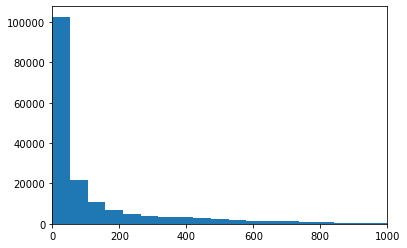

In [5]:
numbers_of_peaks = [len(s.peaks) for s in spectrums_training]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

In [6]:
np.min(np.array(numbers_of_peaks)), np.max(np.array(numbers_of_peaks))

(10, 228989)

## Remove very small peaks 
- remove all peaks with intensities <0.001 max intensity
- keep at max the highest 1000 peaks

In [7]:
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_relative_intensity

def process_peaks(s):
    s = select_by_relative_intensity(s, intensity_from=0.001)
    s = reduce_to_number_of_peaks(s, n_max=1000)
    return s
    
spectrums_training = [process_peaks(s) for s in spectrums_training]
spectrums_val = [process_peaks(s) for s in spectrums_val]

In [8]:
spectrums_training = [s for s in spectrums_training if s is not None]
len(spectrums_training)

177053

(0.0, 1000.0)

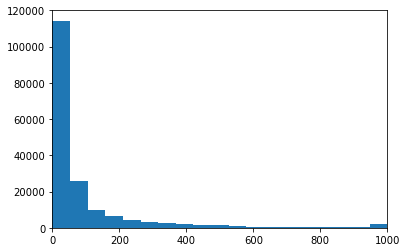

In [9]:
numbers_of_peaks = [len(s.peaks) for s in spectrums_training]
plt.hist(numbers_of_peaks, np.linspace(0,1000,20))
plt.xlim(0, 1000)

# Train default model (10000 -> 500 -> 500 -> 200)

## Create binned spectrums

In [10]:
spectrum_binner = SpectrumBinner(10000, mz_min=10.0, mz_max=1000.0, peak_scaling=0.5,
                                 allowed_missing_percentage=10.0)
binned_spectrums_training = spectrum_binner.fit_transform(spectrums_training)

Collect spectrum peaks...


Spectrum binning:   0%|                                                           | 44/177053 [00:00<06:57, 423.80it/s]

Calculated embedding dimension: 9942.
Convert spectrums to binned spectrums...


Create BinnedSpectrum instances: 100%|██████████████████████████████████████| 177053/177053 [00:05<00:00, 33507.08it/s]


In [11]:
pickle.dump(spectrum_binner, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_training_spectrum_binner_10k.pickle'), "wb"))


In [12]:
binned_spectrums_val = spectrum_binner.transform(spectrums_val)

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████| 5282/5282 [00:00<00:00, 28557.47it/s]


In [13]:
# Just to later save this step when repeating...

pickle.dump(binned_spectrums_training, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_train_split_10k.pickle'), "wb"))

pickle.dump(binned_spectrums_val, 
            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_val_split_10k.pickle'), "wb"))

#pickle.dump(binned_spectrums_test, 
#            open(os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_test_split_10k.pickle'), "wb"))

In [9]:
# Load binned spectrums
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_train_split_10k.pickle')
with open(filename, 'rb') as file:
    binned_spectrums_training = pickle.load(file)

filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_val_split_10k.pickle')
with open(filename, 'rb') as file:
    binned_spectrums_val = pickle.load(file)

In [10]:
# Load spectrum binner
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_data210409_training_spectrum_binner_10k.pickle')
with open(filename, 'rb') as file:
    spectrum_binner = pickle.load(file)

## Train model

### Setup data generator

In [16]:
from ms2deepscore.data_generators import DataGeneratorAllInchikeys

dimension = len(spectrum_binner.known_bins)
same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

selected_inchikeys = np.unique([s.get("inchikey")[:14] for s in spectrums_training])
        
training_generator = DataGeneratorAllInchikeys(binned_spectrums_training, selected_inchikeys,
                                               tanimoto_df,
                                               dim=dimension,
                                               same_prob_bins=same_prob_bins,
                                               num_turns=2,
                                               augment_noise_max=10,
                                               augment_noise_intensity=0.01)

The value for num_turns is set from 1 (default) to 2
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 10
The value for augment_noise_intensity is set from 0.01 (default) to 0.01


In [17]:
selected_inchikeys = np.unique([s.get("inchikey")[:14] for s in spectrums_val])

validation_generator = DataGeneratorAllInchikeys(binned_spectrums_val, selected_inchikeys,
                                                 tanimoto_df,
                                                 dim=dimension,
                                                 same_prob_bins=same_prob_bins,
                                                 num_turns=10,
                                                 augment_removal_max=0,
                                                 augment_removal_intensity=0,
                                                 augment_intensity=0,
                                                 augment_noise_max=0,
                                                 use_fixed_set=True)

The value for num_turns is set from 1 (default) to 10
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0
The value for use_fixed_set is set from False (default) to True


c:\onedrive - netherlands escience center\project_wageningen_iomega\ms2deepscore\ms2deepscore\data_generators.py:180: UserWarning: When using a fixed set, data will not be shuffled
  warnings.warn('When using a fixed set, data will not be shuffled')


In [18]:
model = SiameseModel(spectrum_binner, base_dims=[500, 500], embedding_dim=200,
                     dropout_rate=0.2)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9942)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4971500   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0         
_________________________________________________________________
embedding (Dense)            (None, 200)               100200 

In [19]:
# Save best model and include early stopping
epochs = 150
learning_rate = 0.001
import tensorflow as tf
metrics = ["mae", tf.keras.metrics.RootMeanSquaredError()]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
embedding_dim = 200
filename_base = f"{timestamp}_data210409_10k_500_500_{embedding_dim}"
model_output_file = os.path.join(path_data, "trained_models" , filename_base+".hdf5")

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    verbose=1, 
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

# Save history
filename = os.path.join(path_output, filename_base+'_training_history.pickle')
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/150
990/990 [==============================] - 372s 372ms/step - loss: 0.1103 - mae: 0.1989 - root_mean_squared_error: 0.2459 - val_loss: 0.1006 - val_mae: 0.1743 - val_root_mean_squared_error: 0.2186

Epoch 00001: val_loss improved from inf to 0.10061, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210419-221701_data210409_10k_500_500_200.hdf5
Epoch 2/150
990/990 [==============================] - 315s 318ms/step - loss: 0.1016 - mae: 0.1786 - root_mean_squared_error: 0.2235 - val_loss: 0.0990 - val_mae: 0.1726 - val_root_mean_squared_error: 0.2177

Epoch 00002: val_loss improved from 0.10061 to 0.09898, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210419-221701_data210409_10k_500_500_200.hdf5
Epoch 3/150
990/990 [==============================] - 311s 314ms/step - loss: 0.0971 - mae: 0.1697 - root_mean_squared_error: 0.2137 - val_loss: 0.0969 - val_mae: 0.16

990/990 [==============================] - 303s 306ms/step - loss: 0.0840 - mae: 0.1478 - root_mean_squared_error: 0.1901 - val_loss: 0.0846 - val_mae: 0.1489 - val_root_mean_squared_error: 0.1928

Epoch 00023: val_loss improved from 0.08564 to 0.08456, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210419-221701_data210409_10k_500_500_200.hdf5
Epoch 24/150
990/990 [==============================] - 298s 301ms/step - loss: 0.0817 - mae: 0.1442 - root_mean_squared_error: 0.1856 - val_loss: 0.0848 - val_mae: 0.1513 - val_root_mean_squared_error: 0.1949

Epoch 00024: val_loss did not improve from 0.08456
Epoch 25/150
990/990 [==============================] - 301s 304ms/step - loss: 0.0818 - mae: 0.1450 - root_mean_squared_error: 0.1867 - val_loss: 0.0839 - val_mae: 0.1491 - val_root_mean_squared_error: 0.1929

Epoch 00025: val_loss improved from 0.08456 to 0.08388, saving model to C:\OneDrive - Netherlands eScience Center\Project

990/990 [==============================] - 297s 300ms/step - loss: 0.0735 - mae: 0.1397 - root_mean_squared_error: 0.1800 - val_loss: 0.0766 - val_mae: 0.1442 - val_root_mean_squared_error: 0.1875

Epoch 00047: val_loss did not improve from 0.07549
Epoch 48/150
990/990 [==============================] - 301s 304ms/step - loss: 0.0731 - mae: 0.1384 - root_mean_squared_error: 0.1798 - val_loss: 0.0767 - val_mae: 0.1447 - val_root_mean_squared_error: 0.1872

Epoch 00048: val_loss did not improve from 0.07549
Epoch 49/150
990/990 [==============================] - 295s 298ms/step - loss: 0.0736 - mae: 0.1395 - root_mean_squared_error: 0.1804 - val_loss: 0.0756 - val_mae: 0.1437 - val_root_mean_squared_error: 0.1864

Epoch 00049: val_loss did not improve from 0.07549
Epoch 00049: early stopping


NameError: name 'path_output' is not defined

In [20]:
# Save history
filename = os.path.join(path_data, filename_base+'_training_history.pickle')
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)

In [25]:
model_output_file = os.path.join(path_data, "trained_models" , "ms2ds_"+filename_base+".hdf5")
model.save(model_output_file)

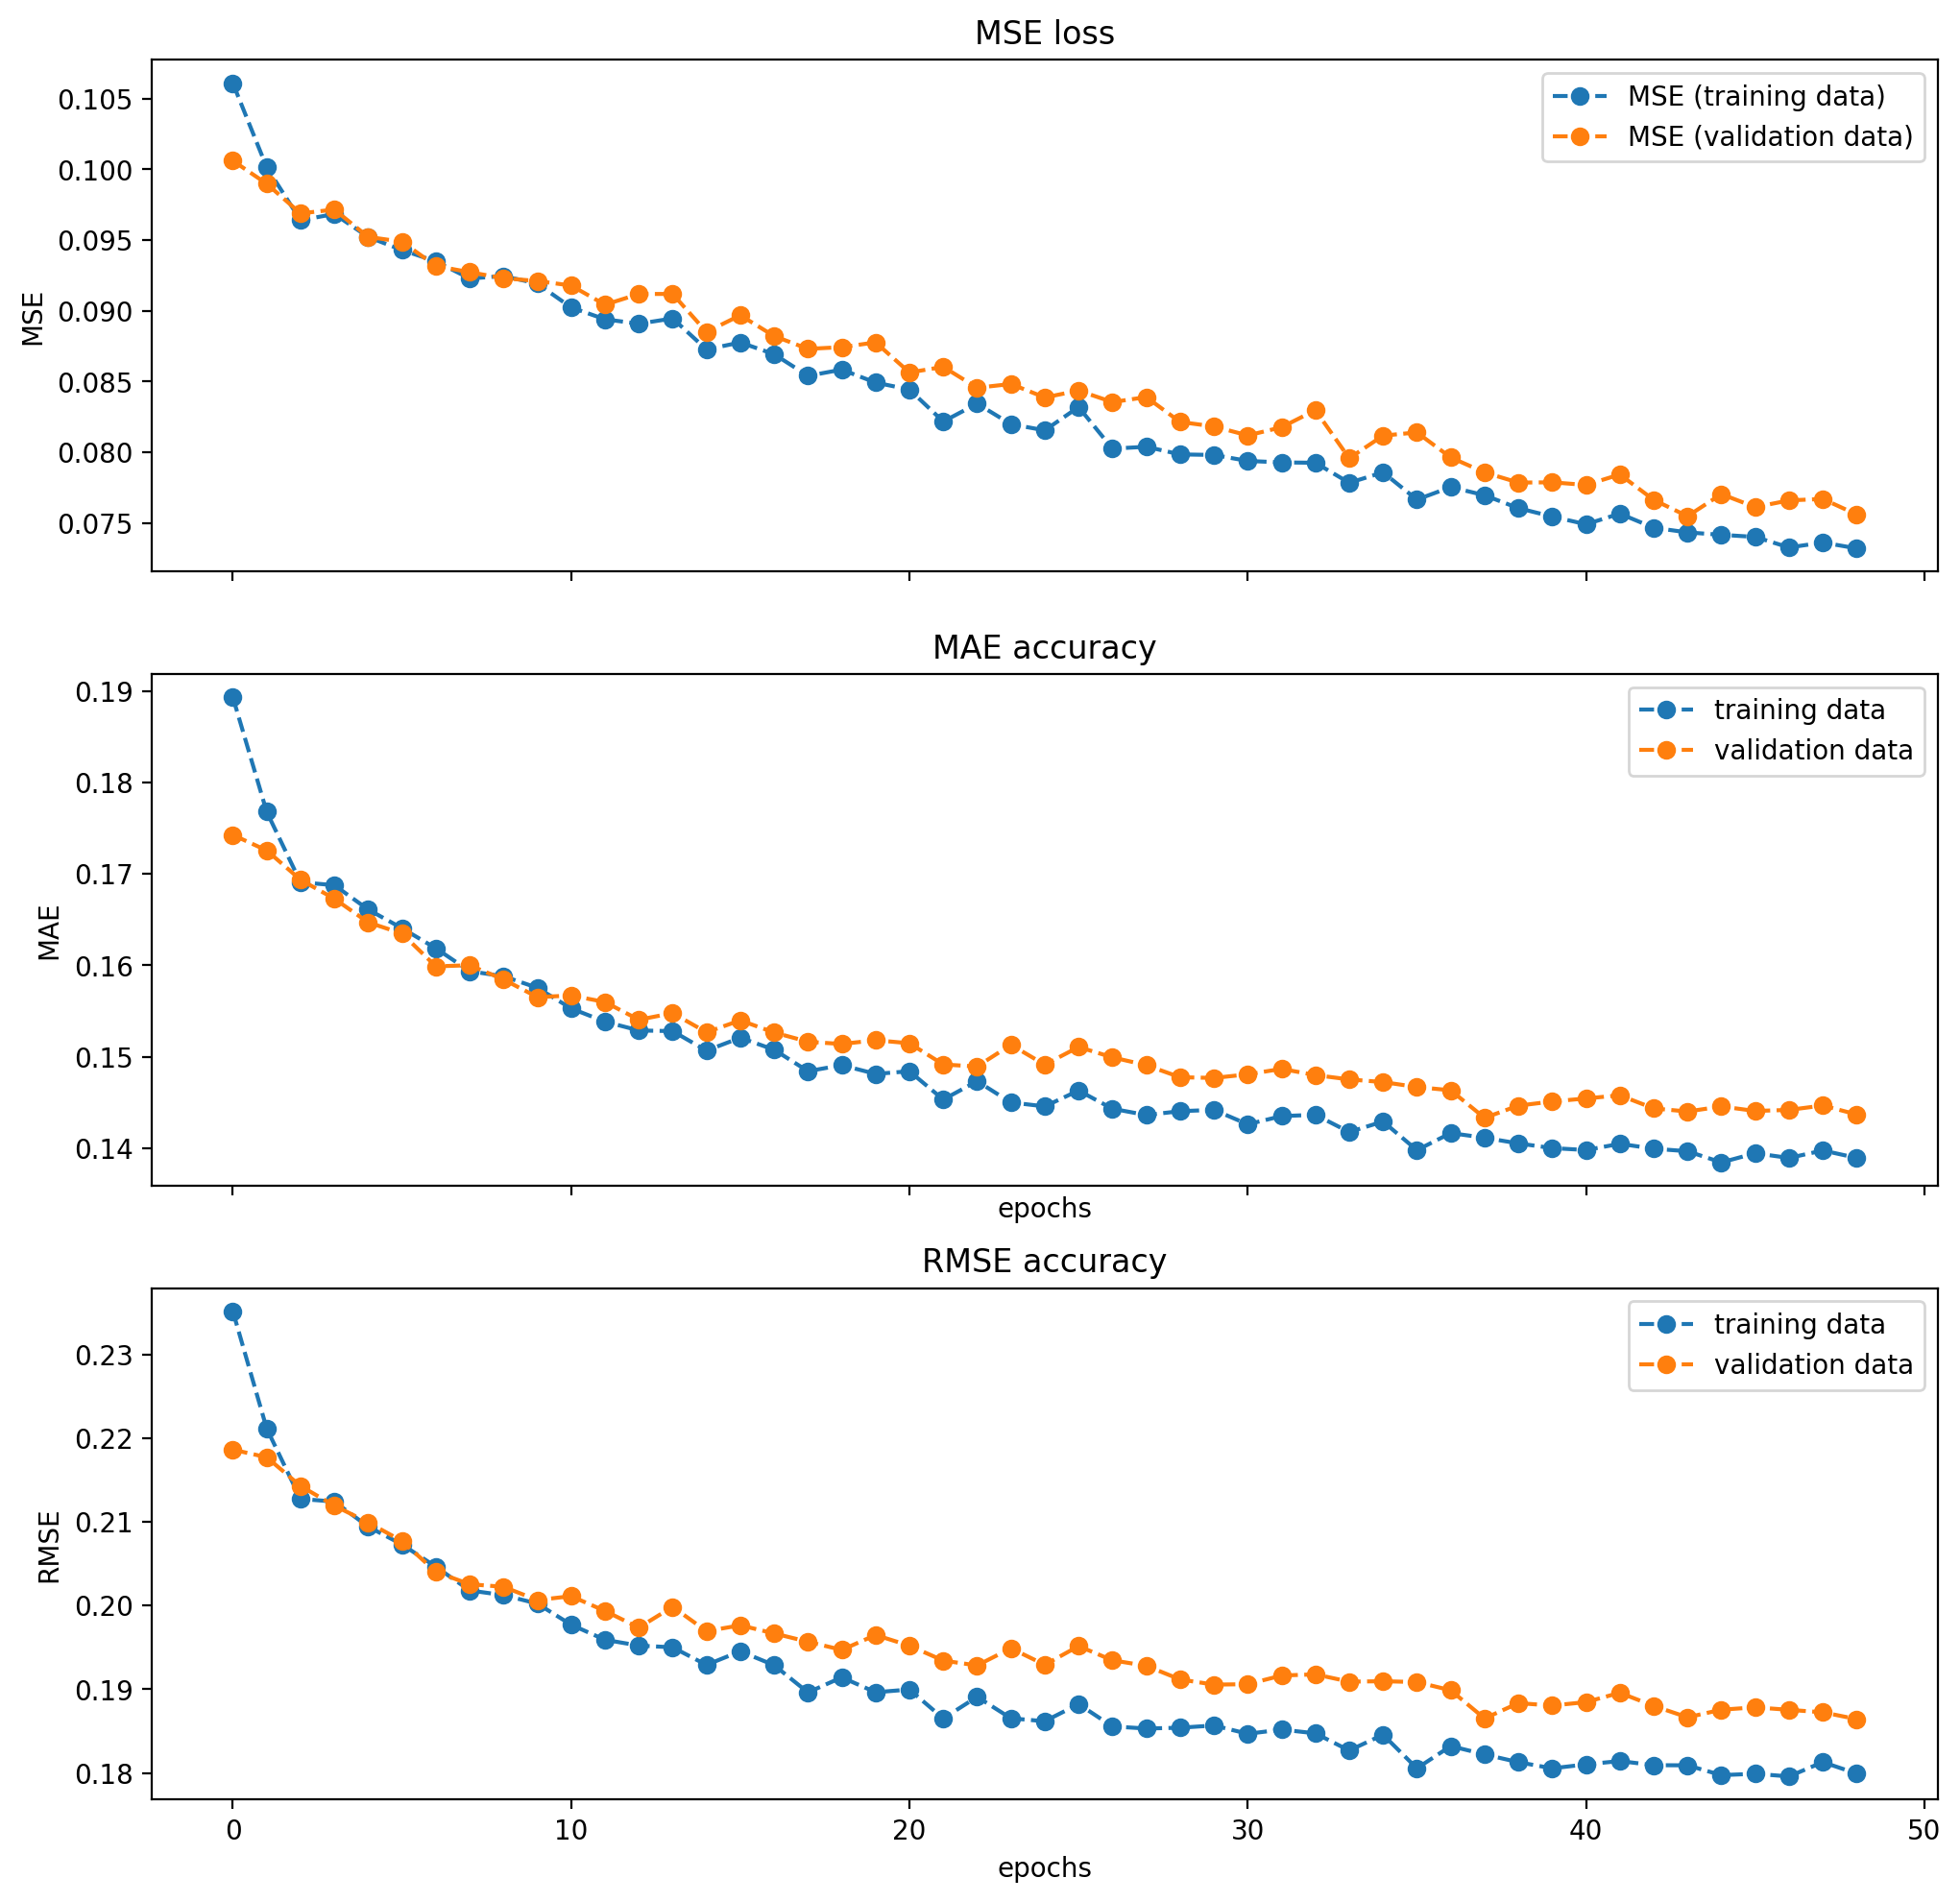

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

ax3.plot(history.history['root_mean_squared_error'], "o--", label='training data')
ax3.plot(history.history['val_root_mean_squared_error'], "o--", label='validation data')
ax3.set_title('RMSE accuracy')
ax3.set_ylabel("RMSE")
ax3.set_xlabel("epochs")
ax3.legend()

In [26]:
history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    verbose=1, 
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

# Save history
filename = os.path.join(path_output, filename_base+'_training_history.pickle')
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/150
7340/7340 [==============================] - 2261s 308ms/step - loss: 0.0930 - mae: 0.1638 - root_mean_squared_error: 0.2075 - val_loss: 0.0909 - val_mae: 0.1586 - val_root_mean_squared_error: 0.2037

Epoch 00001: val_loss improved from 0.09574 to 0.09092, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210410-213119_data210409_10k_500_500_200.hdf5
Epoch 2/150
7340/7340 [==============================] - 2448s 333ms/step - loss: 0.0898 - mae: 0.1616 - root_mean_squared_error: 0.2051 - val_loss: 0.0890 - val_mae: 0.1600 - val_root_mean_squared_error: 0.2051

Epoch 00002: val_loss improved from 0.09092 to 0.08897, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210410-213119_data210409_10k_500_500_200.hdf5
Epoch 3/150
7340/7340 [==============================] - 2604s 350ms/step - loss: 0.0868 - mae: 0.1600 - root_mean_squared_error: 0.2033 - val_loss: 0.0858 - 

KeyboardInterrupt: 

In [60]:
# seems like there's some issues.... check further

numbers_of_peaks = np.array([len(s.peaks) for s in spectrums_training])

(0.0, 100.0)

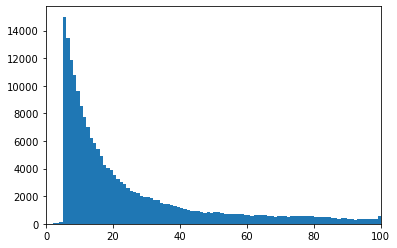

In [28]:
plt.hist(numbers_of_peaks, np.linspace(0,100,101))
plt.xlim(0, 100)

In [64]:
for num in [5, 10, 20]:
    print(np.sum(numbers_of_peaks >= num))

234669
173938
116022


(0.0, 1000.0)

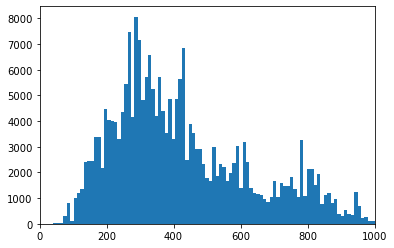

In [29]:
masses = [s.get("parent_mass") for s in spectrums_training]
plt.hist(masses, np.linspace(0,1000,100))
plt.xlim(0, 1000)

In [38]:
from ms2deepscore.data_generators import DataGeneratorAllSpectrums

dimension = len(spectrum_binner.known_bins)
same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

training_generator = DataGeneratorAllSpectrums(binned_spectrums_training, tanimoto_df,
                                               dim=dimension,
                                               batch_size=64,
                                               same_prob_bins=same_prob_bins,
                                               augment_noise_max=5,
                                               augment_noise_intensity=0.02)

The value for batch_size is set from 32 (default) to 64
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 5
The value for augment_noise_intensity is set from 0.01 (default) to 0.02
16085 out of 17085 InChIKeys found in selected spectrums.


In [31]:
validation_generator = DataGeneratorAllSpectrums(binned_spectrums_val, tanimoto_df,
                                                 dim=dimension,
                                                 same_prob_bins=same_prob_bins,
                                                 num_turns=10,
                                                 augment_removal_max=0,
                                                 augment_removal_intensity=0,
                                                 augment_intensity=0,
                                                 augment_noise_max=0,
                                                 use_fixed_set=True)

The value for num_turns is set from 1 (default) to 10
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0
The value for use_fixed_set is set from False (default) to True


c:\onedrive - netherlands escience center\project_wageningen_iomega\ms2deepscore\ms2deepscore\data_generators.py:180: UserWarning: When using a fixed set, data will not be shuffled
  warnings.warn('When using a fixed set, data will not be shuffled')


500 out of 17085 InChIKeys found in selected spectrums.


In [32]:
model = SiameseModel(spectrum_binner, base_dims=[500, 500], embedding_dim=200,
                     dropout_rate=0.2)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9949)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4975000   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0         
_________________________________________________________________
embedding (Dense)            (None, 200)               100200 

In [37]:
model.base.layers[-1].output_shape[1]

200

In [39]:
# Save best model and include early stopping
epochs = 150
learning_rate = 0.001
import tensorflow as tf
metrics = ["mae", tf.keras.metrics.RootMeanSquaredError()]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
embedding_dim = model.base.layers[-1].output_shape[1]
filename_base = f"{timestamp}_data210409_10k_500_500_{embedding_dim}"
model_output_file = os.path.join(path_data, "trained_models" , filename_base+".hdf5")

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    verbose=1, 
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

# Save history
filename = os.path.join(path_output, filename_base+'_training_history.pickle')
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/150
3670/3670 [==============================] - 2414s 654ms/step - loss: 0.1041 - mae: 0.1937 - root_mean_squared_error: 0.2397 - val_loss: 0.0927 - val_mae: 0.1697 - val_root_mean_squared_error: 0.2159

Epoch 00001: val_loss improved from inf to 0.09272, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210411-103943_data210409_10k_500_500_200.hdf5
Epoch 2/150
3670/3670 [==============================] - 2688s 702ms/step - loss: 0.0913 - mae: 0.1693 - root_mean_squared_error: 0.2135 - val_loss: 0.0894 - val_mae: 0.1634 - val_root_mean_squared_error: 0.2079

Epoch 00002: val_loss improved from 0.09272 to 0.08936, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210411-103943_data210409_10k_500_500_200.hdf5
Epoch 3/150
3670/3670 [==============================] - 2445s 640ms/step - loss: 0.0876 - mae: 0.1615 - root_mean_squared_error: 0.2053 - val_loss: 0.0879 - val_

KeyboardInterrupt: 

In [40]:
filename = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210409.pickle')
with open(filename, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectra imported.")

8120 spectra imported.


In [42]:
spectrums_test = [process_peaks(s) for s in spectrums_test]

In [43]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)
similarities_test = similarity_score.matrix(spectrums_test, spectrums_test, is_symmetric=True)

Calculating vectors of reference spectrums: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8120/8120 [09:43<00:00, 13.92it/s]


In [44]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

In [ ]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_test, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")


In [51]:
from ms2deepscore.plotting import create_histograms_plot

numbers_of_peaks_test = np.array([len(s.peaks) for s in spectrums_test])
masses_test = np.array([s.get("parent_mass") for s in spectrums_test])

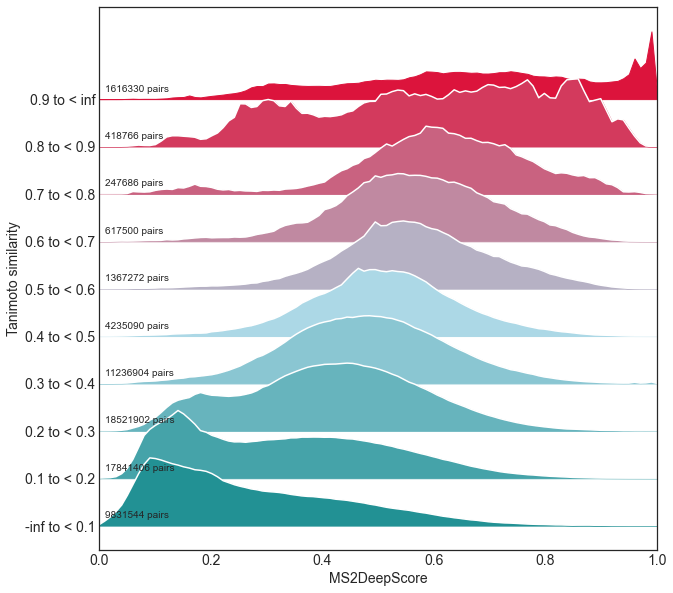

In [58]:
idx_peaks = np.where(numbers_of_peaks_test > 0)[0]
idx =np.ix_(idx_peaks, idx_peaks)

create_histograms_plot(scores_ref[idx], similarities_test[idx], n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

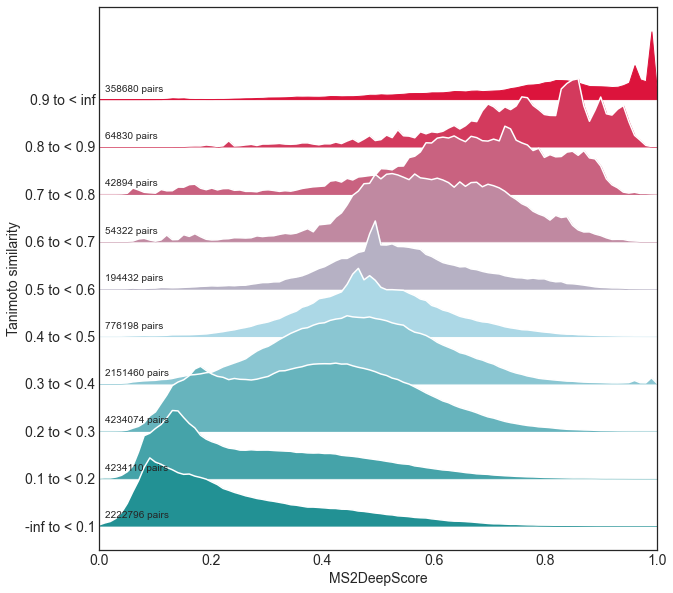

In [49]:
idx_peaks = np.where(numbers_of_peaks_test > 20)[0]
idx =np.ix_(idx_peaks, idx_peaks)

create_histograms_plot(scores_ref[idx], similarities_test[idx], n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

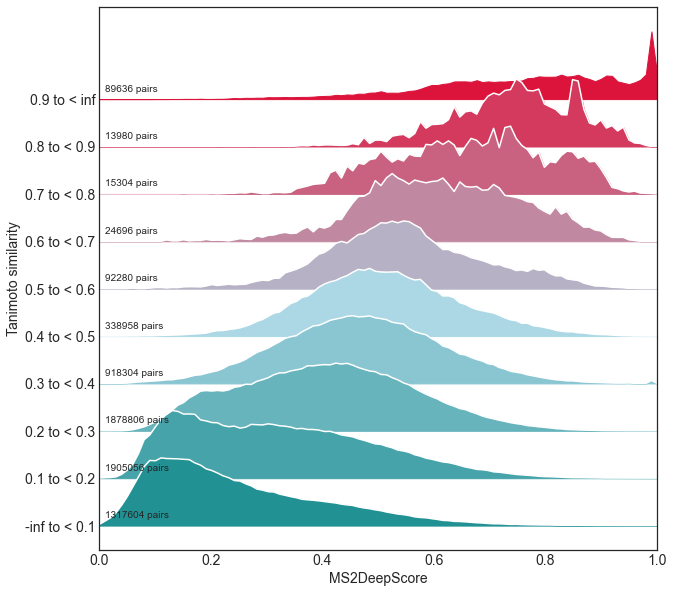

In [53]:
idx_peaks = np.where(numbers_of_peaks_test/masses_test > 20/200)[0]
idx =np.ix_(idx_peaks, idx_peaks)

create_histograms_plot(scores_ref[idx], similarities_test[idx], n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

(3786,)


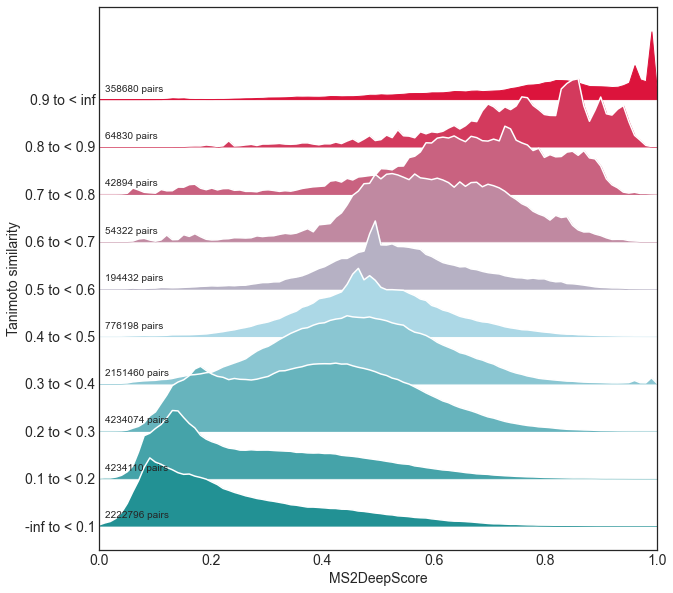

In [59]:
idx_peaks = np.where((numbers_of_peaks_test > 20) & (masses_test > 100))[0]
print(idx_peaks.shape)
idx =np.ix_(idx_peaks, idx_peaks)

create_histograms_plot(scores_ref[idx], similarities_test[idx], n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

# Train on "beter quality" data only

In [7]:
inchikeys14_training = np.array([s.get("inchikey")[:14] for s in spectrums_training])
number_peaks_training = np.array([len(s.peaks) for s in spectrums_training])

In [11]:
min_num_peaks = 10
binned_spectrums_training_select = []

for inchikey14 in np.unique(inchikeys14_training):
    idx = np.where(inchikeys14_training == inchikey14)[0]
    lengths = number_peaks_training[idx]
    select = np.where(lengths >= min_num_peaks)[0]
    if select.shape[0] == 0:
        select = np.argmax(lengths)
    idx_select = idx[select]
    if isinstance(idx_select, np.int64):
        idx_select = [idx_select]
    binned_spectrums_training_select += [binned_spectrums_training[i] for i in idx_select]

In [85]:
idx_select

110532

In [12]:
len(binned_spectrums_training_select), len(binned_spectrums_training)

(174662, 234889)

In [13]:
min_num_peaks = 10
binned_spectrums_val_select = []

inchikeys14_val = np.array([s.get("inchikey")[:14] for s in spectrums_val])
number_peaks_val = np.array([len(s.peaks) for s in spectrums_val])

for inchikey14 in np.unique(inchikeys14_val):
    idx = np.where(inchikeys14_val == inchikey14)[0]
    lengths = number_peaks_val[idx]
    select = np.where(lengths >= min_num_peaks)[0]
    if select.shape[0] == 0:
        select = np.argmax(lengths)
    idx_select = idx[select]
    if isinstance(idx_select, np.int64):
        idx_select = [idx_select]
    binned_spectrums_val_select += [binned_spectrums_val[i] for i in idx_select]

In [14]:
from ms2deepscore.data_generators import DataGeneratorAllSpectrums

dimension = len(spectrum_binner.known_bins)
same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

training_generator = DataGeneratorAllSpectrums(binned_spectrums_training_select, tanimoto_df,
                                               dim=dimension,
                                               batch_size=32,
                                               same_prob_bins=same_prob_bins,
                                               augment_noise_max=5,
                                               augment_noise_intensity=0.02)

The value for batch_size is set from 32 (default) to 32
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 5
The value for augment_noise_intensity is set from 0.01 (default) to 0.02
16085 out of 17085 InChIKeys found in selected spectrums.


In [15]:
validation_generator = DataGeneratorAllSpectrums(binned_spectrums_val_select, tanimoto_df,
                                                 dim=dimension,
                                                 same_prob_bins=same_prob_bins,
                                                 num_turns=10,
                                                 augment_removal_max=0,
                                                 augment_removal_intensity=0,
                                                 augment_intensity=0,
                                                 augment_noise_max=0,
                                                 use_fixed_set=True)

The value for num_turns is set from 1 (default) to 10
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0
The value for use_fixed_set is set from False (default) to True


c:\onedrive - netherlands escience center\project_wageningen_iomega\ms2deepscore\ms2deepscore\data_generators.py:180: UserWarning: When using a fixed set, data will not be shuffled
  warnings.warn('When using a fixed set, data will not be shuffled')


500 out of 17085 InChIKeys found in selected spectrums.


In [16]:
model = SiameseModel(spectrum_binner, base_dims=[500, 500], embedding_dim=200,
                     dropout_rate=0.2)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9949)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               4975000   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dense2 (Dense)               (None, 500)               250500    
_________________________________________________________________
normalization2 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout2 (Dropout)           (None, 500)               0         
_________________________________________________________________
embedding (Dense)            (None, 200)               100200 

In [17]:
# Save best model and include early stopping
epochs = 150
learning_rate = 0.001
import tensorflow as tf
metrics = ["mae", tf.keras.metrics.RootMeanSquaredError()]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
embedding_dim = model.base.layers[-1].output_shape[1]
filename_base = f"{timestamp}_data210409_10k_500_500_{embedding_dim}"
model_output_file = os.path.join(path_data, "trained_models" , filename_base+".hdf5")

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    verbose=1, 
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

# Save history
filename = os.path.join(path_output, filename_base+'_training_history.pickle')
with open(filename, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/150
5458/5458 [==============================] - 2090s 382ms/step - loss: 0.1089 - mae: 0.1945 - root_mean_squared_error: 0.2411 - val_loss: 0.0989 - val_mae: 0.1672 - val_root_mean_squared_error: 0.2149

Epoch 00001: val_loss improved from inf to 0.09885, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210411-193040_data210409_10k_500_500_200.hdf5
Epoch 2/150
5458/5458 [==============================] - 5191s 931ms/step - loss: 0.0995 - mae: 0.1714 - root_mean_squared_error: 0.2159 - val_loss: 0.0958 - val_mae: 0.1631 - val_root_mean_squared_error: 0.2093

Epoch 00002: val_loss improved from 0.09885 to 0.09583, saving model to C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\trained_models\20210411-193040_data210409_10k_500_500_200.hdf5
Epoch 3/150
5458/5458 [==============================] - 2174s 390ms/step - loss: 0.0956 - mae: 0.1643 - root_mean_squared_error: 0.2083 - val_loss: 0.0934 - val_

KeyboardInterrupt: 

In [18]:
len(binned_spectrums_val_select)

5337

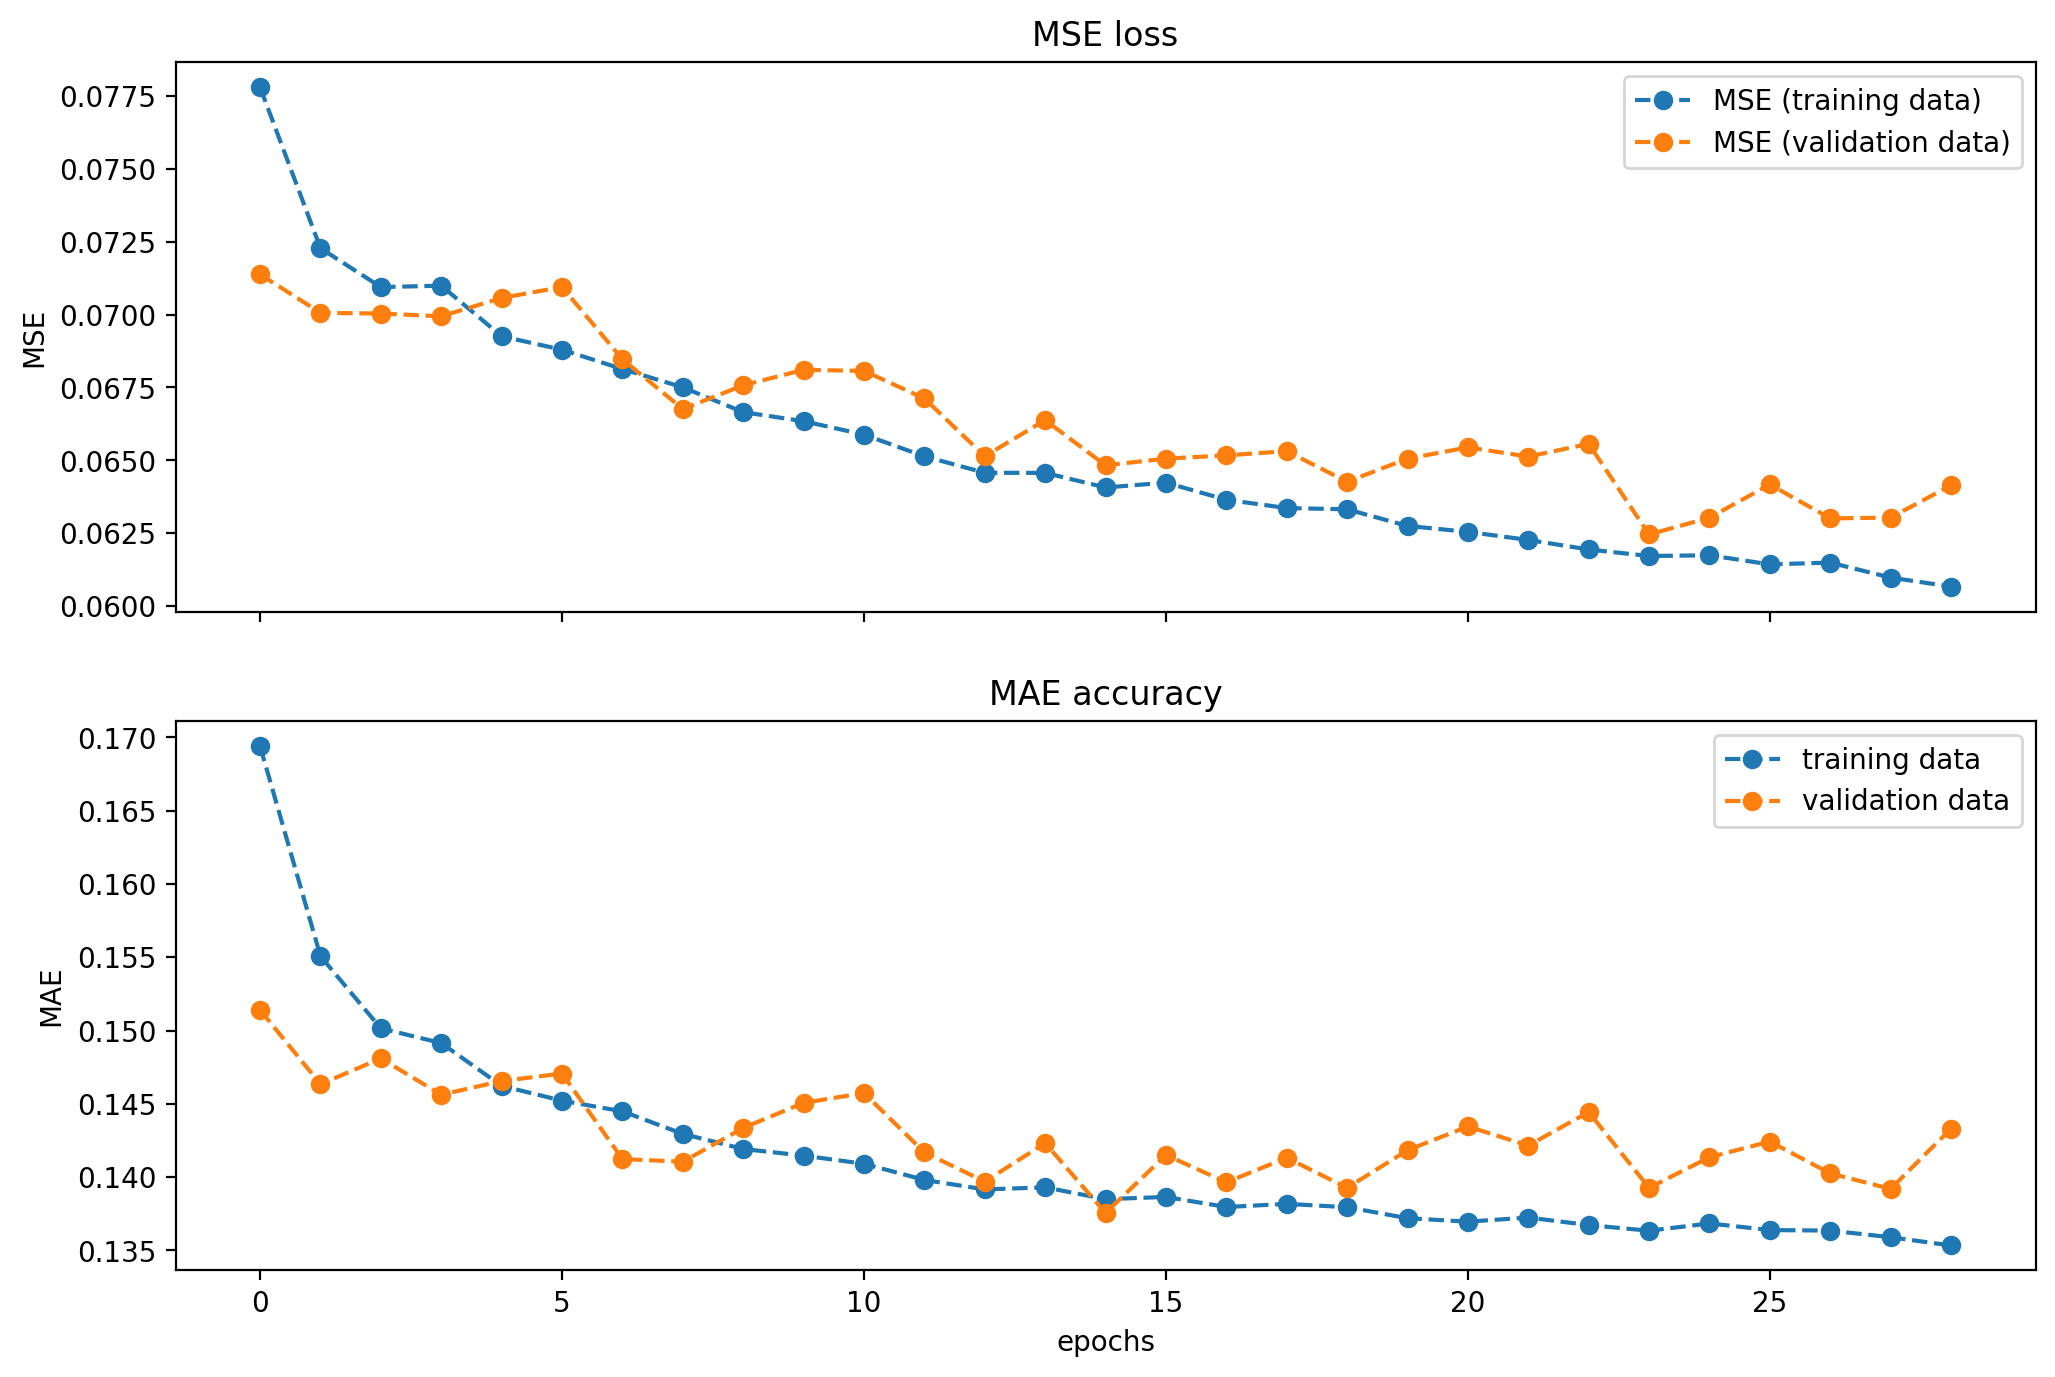

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

## Train model

### Setup data generator

In [ ]:
from ms2deepscore.data_generators import DataGeneratorAllInchikey

dimension = len(spectrum_binner.known_bins)
same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

training_generator = DataGeneratorAllSpectrums(binned_spectrums_training, tanimoto_df,
                                               dim=dimension,
                                               same_prob_bins=same_prob_bins,
                                               augment_noise_max=30,
                                               augment_noise_intensity=0.05)

In [25]:
validation_generator = DataGeneratorAllSpectrums(binned_spectrums_val, tanimoto_df,
                                                 dim=dimension,
                                                 same_prob_bins=same_prob_bins,
                                                 num_turns=10,
                                                 augment_removal_max=0,
                                                 augment_removal_intensity=0,
                                                 augment_intensity=0,
                                                 augment_noise_max=0,
                                                 use_fixed_set=True)

The value for num_turns is set from 1 (default) to 10
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0
The value for use_fixed_set is set from False (default) to True


c:\onedrive - netherlands escience center\project_wageningen_iomega\ms2deepscore\ms2deepscore\data_generators.py:180: UserWarning: When using a fixed set, data will not be shuffled
  warnings.warn('When using a fixed set, data will not be shuffled')


500 out of 17085 InChIKeys found in selected spectrums.


In [47]:
with open('ms2ds_210301_5000_500_400_training_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [48]:
# Save ms2deepscore style model (containing the SpectrumBinner)
model.save("ms2ds_siamese_210301_5000_500_400.hdf5")

# Try bit deeper architecture

In [50]:
model = SiameseModel(spectrum_binner, base_dims=[500, 600, 600, 500], embedding_dim=400,
                     dropout_rate=0.25)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 4993)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 500)               2497000   
_________________________________________________________________
normalization1 (BatchNormali (None, 500)               2000      
_________________________________________________________________
dropout1 (Dropout)           (None, 500)               0         
_________________________________________________________________
dense2 (Dense)               (None, 600)               300600    
_________________________________________________________________
normalization2 (BatchNormali (None, 600)               2400      
_________________________________________________________________
dropout2 (Dropout)           (None, 600)               0      

In [51]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210301_5000_500_600_600_500_400.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3204/3204 [==============================] - 667s 207ms/step - loss: 0.1334 - mae: 0.1977 - val_loss: 0.1226 - val_mae: 0.1867

Epoch 00001: val_loss improved from inf to 0.12256, saving model to ms2ds_210301_5000_500_600_600_500_400.hdf5
Epoch 2/150
3204/3204 [==============================] - 645s 201ms/step - loss: 0.1158 - mae: 0.1773 - val_loss: 0.1161 - val_mae: 0.1825

Epoch 00002: val_loss improved from 0.12256 to 0.11613, saving model to ms2ds_210301_5000_500_600_600_500_400.hdf5
Epoch 3/150
3204/3204 [==============================] - 644s 201ms/step - loss: 0.1097 - mae: 0.1728 - val_loss: 0.1174 - val_mae: 0.1873

Epoch 00003: val_loss did not improve from 0.11613
Epoch 4/150
3204/3204 [==============================] - 647s 202ms/step - loss: 0.1076 - mae: 0.1726 - val_loss: 0.1114 - val_mae: 0.1823

Epoch 00004: val_loss improved from 0.11613 to 0.11135, saving model to ms2ds_210301_5000_500_600_600_500_400.hdf5
Epoch 5/150
3204/3204 [=========================

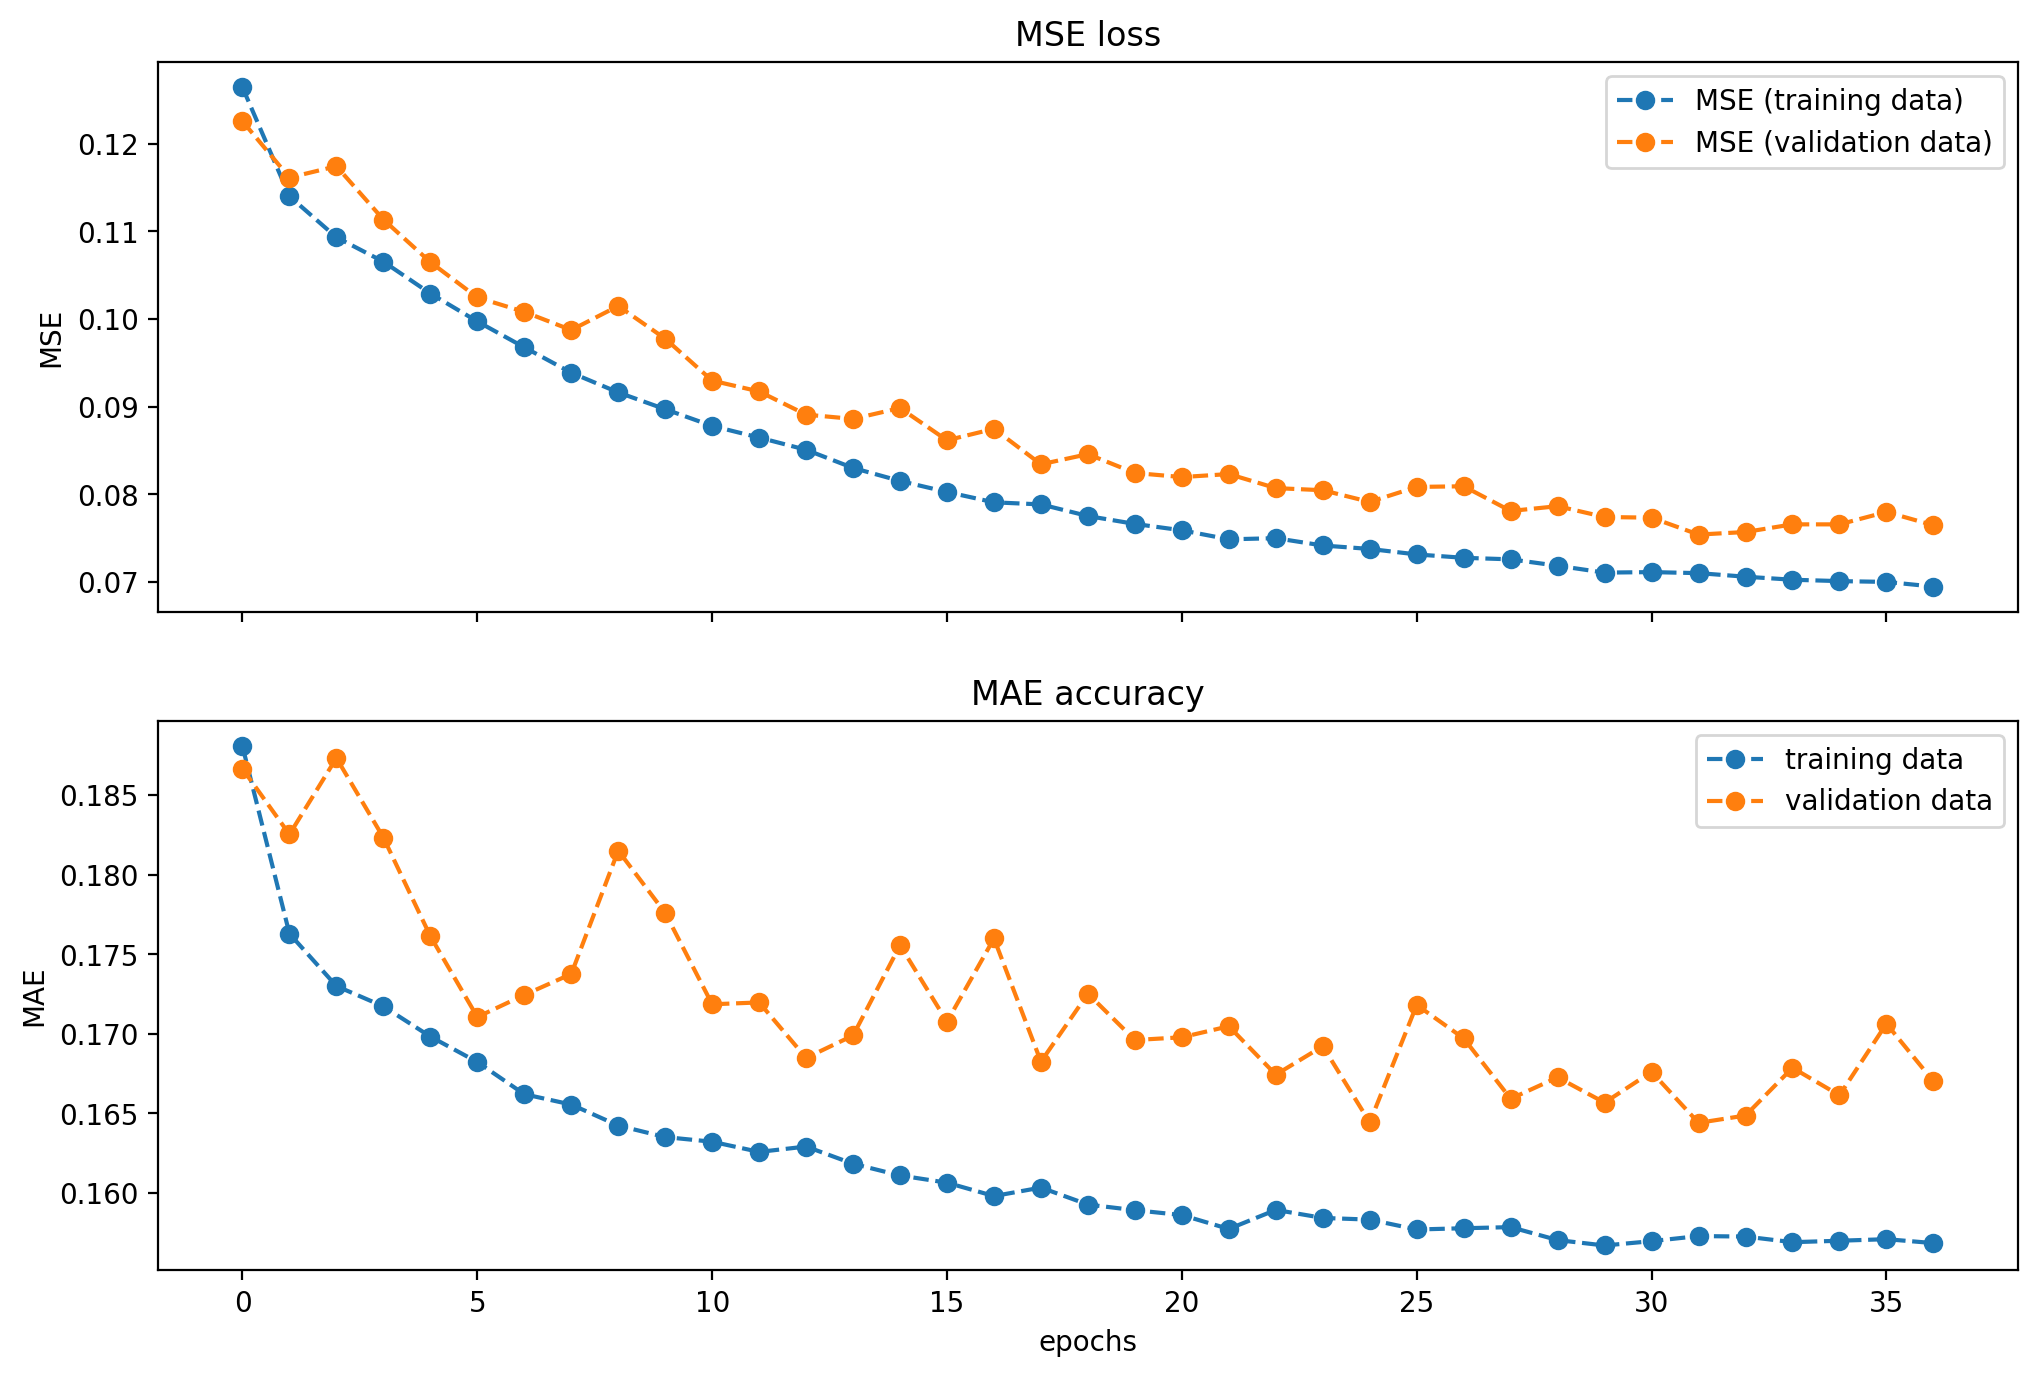

In [52]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [53]:
with open('ms2ds_210301_5000_500_600_600_500_400_training_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [54]:
# Save ms2deepscore style model (containing the SpectrumBinner)
model.save("ms2ds_siamese_210301_5000_500_600_600_500_400.hdf5")

# Try deeper, wider architecture (more funnel...)

In [12]:
model = SiameseModel(spectrum_binner, base_dims=[1000, 600, 500], embedding_dim=400,
                     dropout_rate=0.25)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 4993)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 1000)              4994000   
_________________________________________________________________
normalization1 (BatchNormali (None, 1000)              4000      
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
dense2 (Dense)               (None, 600)               600600    
_________________________________________________________________
normalization2 (BatchNormali (None, 600)               2400      
_________________________________________________________________
dropout2 (Dropout)           (None, 600)               0      

In [14]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210301_5000_1000_600_500_400.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3204/3204 [==============================] - 1109s 344ms/step - loss: 0.1448 - mae: 0.1902 - val_loss: 0.1235 - val_mae: 0.1747

Epoch 00001: val_loss improved from inf to 0.12346, saving model to ms2ds_210301_5000_1000_600_500_400.hdf5
Epoch 2/150
3204/3204 [==============================] - 808s 252ms/step - loss: 0.1218 - mae: 0.1732 - val_loss: 0.1175 - val_mae: 0.1686

Epoch 00002: val_loss improved from 0.12346 to 0.11755, saving model to ms2ds_210301_5000_1000_600_500_400.hdf5
Epoch 3/150
3204/3204 [==============================] - 738s 230ms/step - loss: 0.1161 - mae: 0.1691 - val_loss: 0.1114 - val_mae: 0.1654

Epoch 00003: val_loss improved from 0.11755 to 0.11143, saving model to ms2ds_210301_5000_1000_600_500_400.hdf5
Epoch 4/150
3204/3204 [==============================] - 741s 231ms/step - loss: 0.1108 - mae: 0.1670 - val_loss: 0.1091 - val_mae: 0.1672

Epoch 00004: val_loss improved from 0.11143 to 0.10911, saving model to ms2ds_210301_5000_1000_600_500_400.

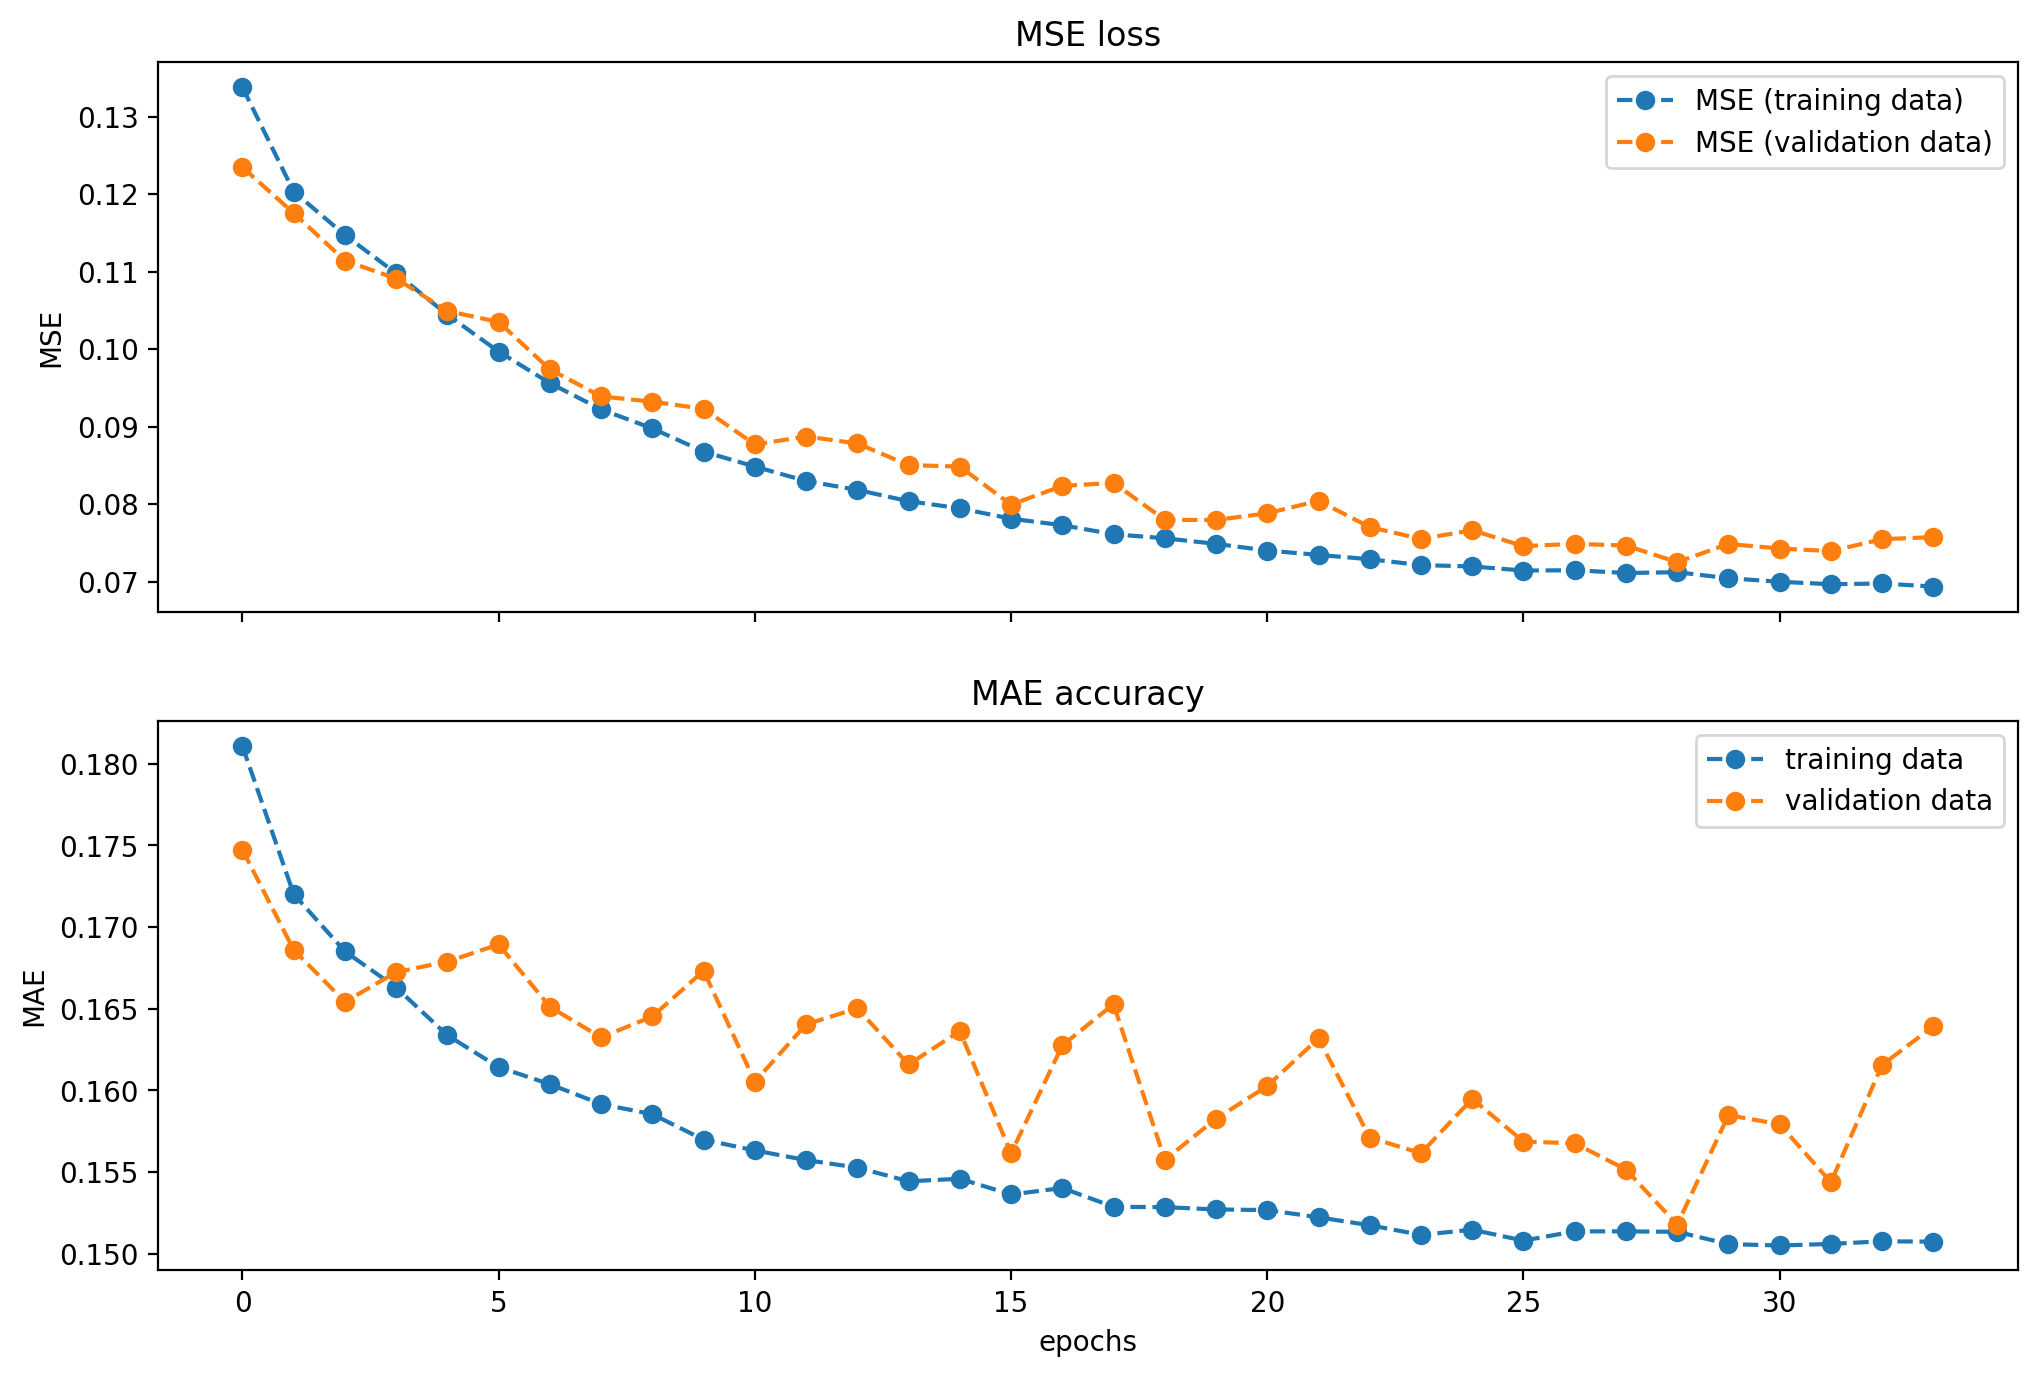

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [16]:
with open('ms2ds_210301_5000_1000_600_500_400_training_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
# Save ms2deepscore style model (containing the SpectrumBinner)
model.save("ms2ds_siamese_210301_5000_1000_600_500_400.hdf5")

# Try other deeper architecture 
- 3 dense layers
- embedding_dim = 300
- learning rate higher

In [8]:
model = SiameseModel(spectrum_binner, base_dims=[600, 600, 600], embedding_dim=300,
                     dropout_rate=0.25)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 4993)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 600)               2996400   
_________________________________________________________________
normalization1 (BatchNormali (None, 600)               2400      
_________________________________________________________________
dropout1 (Dropout)           (None, 600)               0         
_________________________________________________________________
dense2 (Dense)               (None, 600)               360600    
_________________________________________________________________
normalization2 (BatchNormali (None, 600)               2400      
_________________________________________________________________
dropout2 (Dropout)           (None, 600)               0      

In [9]:
epochs = 150
learning_rate = 0.002
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 10
model_output_file = "ms2ds_210301_5000_600_600_600_300.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3204/3204 [==============================] - 772s 239ms/step - loss: 0.1403 - mae: 0.1956 - val_loss: 0.1352 - val_mae: 0.1795

Epoch 00001: val_loss improved from inf to 0.13516, saving model to ms2ds_210301_5000_600_600_600_300.hdf5
Epoch 2/150
3204/3204 [==============================] - 696s 217ms/step - loss: 0.1344 - mae: 0.1797 - val_loss: 0.1307 - val_mae: 0.1781

Epoch 00002: val_loss improved from 0.13516 to 0.13067, saving model to ms2ds_210301_5000_600_600_600_300.hdf5
Epoch 3/150
3204/3204 [==============================] - 689s 215ms/step - loss: 0.1274 - mae: 0.1756 - val_loss: 0.1237 - val_mae: 0.1741

Epoch 00003: val_loss improved from 0.13067 to 0.12367, saving model to ms2ds_210301_5000_600_600_600_300.hdf5
Epoch 4/150
3204/3204 [==============================] - 654s 204ms/step - loss: 0.1204 - mae: 0.1729 - val_loss: 0.1146 - val_mae: 0.1720

Epoch 00004: val_loss improved from 0.12367 to 0.11464, saving model to ms2ds_210301_5000_600_600_600_300.hdf5


KeyboardInterrupt: 

# Try larger architecture

In [11]:
model = SiameseModel(spectrum_binner, base_dims=(1000, 800, 600), embedding_dim=400,
                     dropout_rate=0.25)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 4993)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 1000)              4994000   
_________________________________________________________________
normalization1 (BatchNormali (None, 1000)              4000      
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
dense2 (Dense)               (None, 800)               800800    
_________________________________________________________________
normalization2 (BatchNormali (None, 800)               3200      
_________________________________________________________________
dropout2 (Dropout)           (None, 800)               0      

In [24]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210301_10000_1000_800_600_400.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3166/3166 [==============================] - 1505s 475ms/step - loss: 0.1329 - mae: 0.1893 - val_loss: 0.1209 - val_mae: 0.1812

Epoch 00001: val_loss improved from inf to 0.12090, saving model to ms2ds_210301_10000_1000_800_600_400.hdf5
Epoch 2/150
3166/3166 [==============================] - 2221s 701ms/step - loss: 0.1141 - mae: 0.1681 - val_loss: 0.1151 - val_mae: 0.1708

Epoch 00002: val_loss improved from 0.12090 to 0.11510, saving model to ms2ds_210301_10000_1000_800_600_400.hdf5
Epoch 3/150
3166/3166 [==============================] - 1733s 547ms/step - loss: 0.1099 - mae: 0.1625 - val_loss: 0.1110 - val_mae: 0.1727

Epoch 00003: val_loss improved from 0.11510 to 0.11096, saving model to ms2ds_210301_10000_1000_800_600_400.hdf5
Epoch 4/150
3166/3166 [==============================] - 922s 291ms/step - loss: 0.1058 - mae: 0.1597 - val_loss: 0.1067 - val_mae: 0.1664

Epoch 00004: val_loss improved from 0.11096 to 0.10674, saving model to ms2ds_210301_10000_1000_800_60

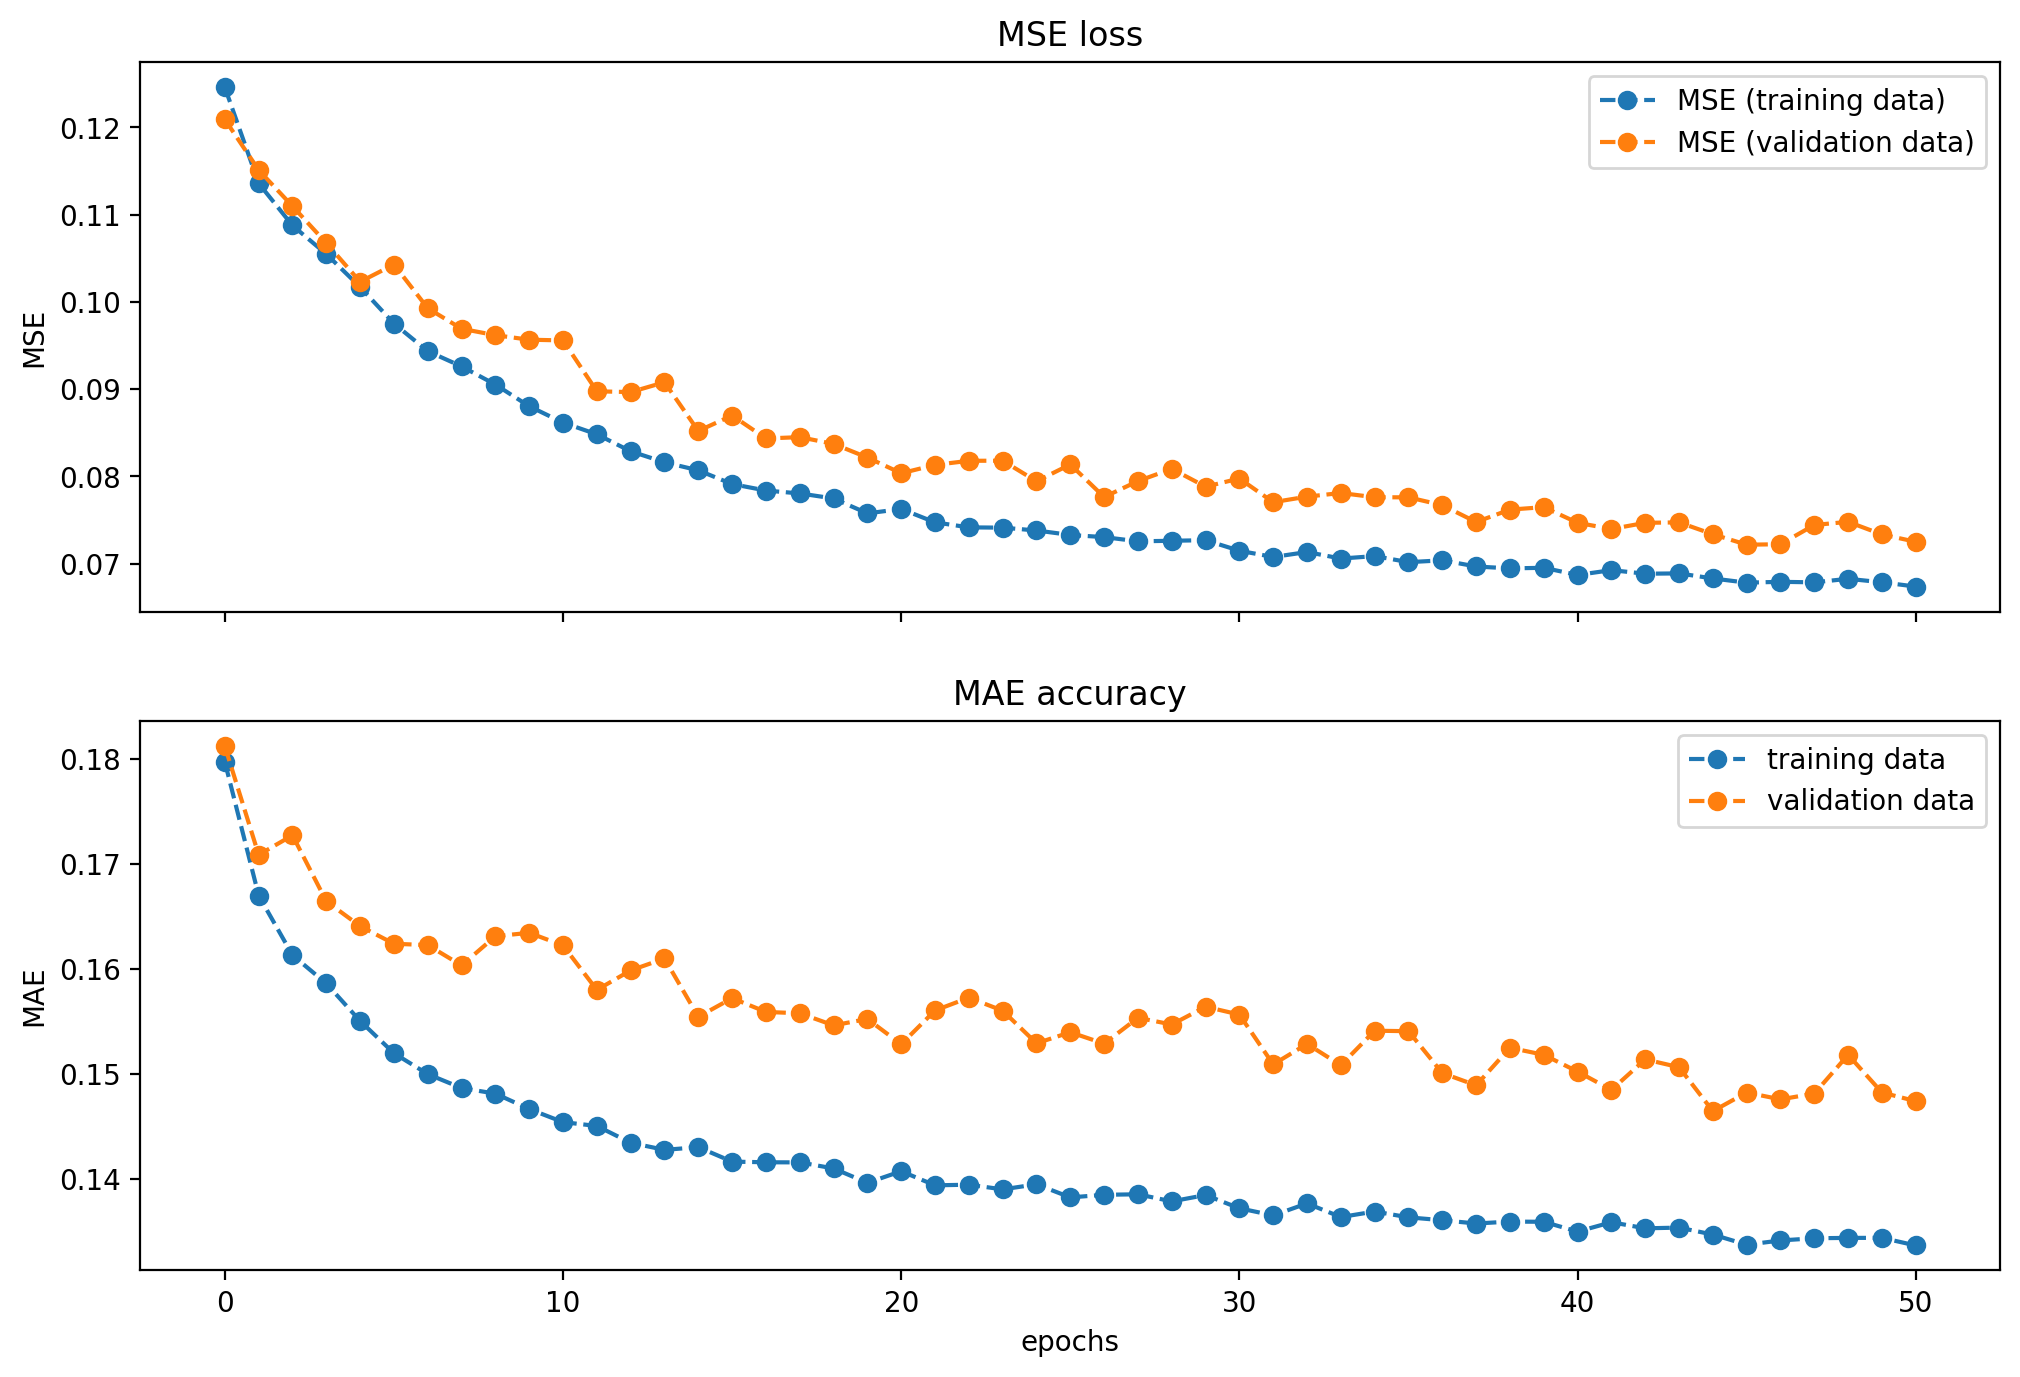

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [18]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210301_10000_1000_800_600_400.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
 105/3166 [..............................] - ETA: 17:58 - loss: 0.1656 - mae: 0.2249

KeyboardInterrupt: 

In [60]:
epochs = 150
learning_rate = 0.002
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210205_ALL_GNPS_positive.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3074/3074 [==============================] - 733s 237ms/step - loss: 0.0587 - mae: 0.1936 - val_loss: 0.0481 - val_mae: 0.1725

Epoch 00001: val_loss improved from inf to 0.04814, saving model to ms2ds_210205_ALL_GNPS_positive.hdf5
Epoch 2/150
3074/3074 [==============================] - 679s 221ms/step - loss: 0.0449 - mae: 0.1661 - val_loss: 0.0443 - val_mae: 0.1664

Epoch 00002: val_loss improved from 0.04814 to 0.04431, saving model to ms2ds_210205_ALL_GNPS_positive.hdf5
Epoch 3/150
3074/3074 [==============================] - 649s 211ms/step - loss: 0.0392 - mae: 0.1540 - val_loss: 0.0435 - val_mae: 0.1632

Epoch 00003: val_loss improved from 0.04431 to 0.04346, saving model to ms2ds_210205_ALL_GNPS_positive.hdf5
Epoch 4/150
3074/3074 [==============================] - 636s 207ms/step - loss: 0.0373 - mae: 0.1490 - val_loss: 0.0434 - val_mae: 0.1617

Epoch 00004: val_loss improved from 0.04346 to 0.04343, saving model to ms2ds_210205_ALL_GNPS_positive.hdf5
Epoch 5/150


KeyboardInterrupt: 

In [73]:
type(history)

NoneType

In [81]:
from pathlib import Path
from typing import Tuple, Union
import h5py
from tensorflow import keras
from tensorflow.python.keras.saving import hdf5_format

from ms2deepscore import SpectrumBinner


class SiameseModel:
    """
    Class for training and evaluating a siamese neural network, implemented in Tensorflow Keras.
    It consists of a dense 'base' network that produces an embedding for each of the 2 inputs. The
    'head' model computes the cosine similarity between the embeddings.

    Mimics keras.Model API.

    For example:

    .. code-block:: python

        # Import data and reference scores --> spectrums & tanimoto_scores_df

        # Create binned spectrums
        spectrum_binner = SpectrumBinner(1000, mz_min=10.0, mz_max=1000.0, peak_scaling=0.5)
        binned_spectrums = spectrum_binner.fit_transform(spectrums)

        # Create generator
        dimension = len(spectrum_binner.known_bins)
        test_generator = DataGeneratorAllSpectrums(binned_spectrums, tanimoto_scores_df,
                                                   dim=dimension)

        # Create (and train) a Siamese model
        model = SiameseModel(spectrum_binner, base_dims=(600, 500, 400), embedding_dim=400,
                             dropout_rate=0.2)
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
        model.summary()
        model.fit(test_generator,
                  validation_data=test_generator,
                  epochs=50)

    """
    def __init__(self,
                 spectrum_binner: SpectrumBinner,
                 base_dims: Tuple[int, int, int] = (600, 500, 500),
                 embedding_dim: int = 400,
                 dropout_rate: float = 0.5,
                 keras_model: keras.Model = None):
        """
        Construct SiameseModel

        Parameters
        ----------
        spectrum_binner
            SpectrumBinner which is used to bin the spectra data for the model training.
        base_dims
            Size-3 tuple of integers depicting the dimensions of the 1st, 2nd, and 3rd hidden
            layers of the base model
        embedding_dim
            Dimension of the embedding (i.e. the output of the base model)
        dropout_rate
            Dropout rate to be used in the base model
        keras_model
            When provided, this keras model will be used to construct the SiameseModel instance.
            Default is None.
        """
        # pylint: disable=too-many-arguments
        assert spectrum_binner.known_bins is not None, \
            "spectrum_binner does not contain known bins (run .fit_transform() on training data first!)"
        self.spectrum_binner = spectrum_binner
        self.input_dim = len(spectrum_binner.known_bins)

        if keras_model is None:
            # Create base model
            self.base = self._get_base_model(input_dim=self.input_dim,
                                             dims=base_dims,
                                             embedding_dim=embedding_dim,
                                             dropout_rate=dropout_rate)
            # Create head model
            self.model = self._get_head_model(input_dim=self.input_dim,
                                              base_model=self.base)
        else:
            self._construct_from_keras_model(keras_model)

    def save(self, filename: Union[str, Path]):
        """
        Save model to file.

        Parameters
        ----------
        filename
            Filename to specify where to store the model.

        """
        with h5py.File(filename, mode='w') as f:
            hdf5_format.save_model_to_hdf5(self.model, f)
            f.attrs['spectrum_binner'] = self.spectrum_binner.to_json()

    @staticmethod
    def _get_base_model(input_dim: int,
                        dims: Tuple[int, int, int] = (600, 500, 500),
                        embedding_dim: int = 400,
                        dropout_rate: float = 0.25):
        model_input = keras.layers.Input(shape=input_dim, name='base_input')
        embedding = keras.layers.Dense(dims[0], activation='relu', name='dense1',
                                       kernel_regularizer=keras.regularizers.l1_l2(l1=1e-6, l2=1e-6))(model_input)
        embedding = keras.layers.BatchNormalization(name='normalization1')(embedding)
        embedding = keras.layers.Dropout(dropout_rate, name='dropout1')(embedding)
        embedding = keras.layers.Dense(dims[1], activation='relu', name='dense2')(embedding)
        embedding = keras.layers.BatchNormalization(name='normalization2')(embedding)
        embedding = keras.layers.Dropout(dropout_rate, name='dropout2')(embedding)
        embedding = keras.layers.Dense(dims[2], activation='relu', name='dense3')(embedding)
        embedding = keras.layers.BatchNormalization(name='normalization3')(embedding)
        embedding = keras.layers.Dropout(dropout_rate, name='dropout3')(embedding)
        embedding = keras.layers.Dense(embedding_dim, activation='relu', name='embedding')(
            embedding)
        return keras.Model(model_input, embedding, name='base')

    @staticmethod
    def _get_head_model(input_dim: int,
                        base_model: keras.Model):
        input_a = keras.layers.Input(shape=input_dim, name="input_a")
        input_b = keras.layers.Input(shape=input_dim, name="input_b")
        embedding_a = base_model(input_a)
        embedding_b = base_model(input_b)
        cosine_similarity = keras.layers.Dot(axes=(1, 1),
                                             normalize=True,
                                             name="cosine_similarity")([embedding_a, embedding_b])
        return keras.Model(inputs=[input_a, input_b], outputs=[cosine_similarity],
                           name='head')

    def _construct_from_keras_model(self, keras_model):
        assert isinstance(keras_model, keras.Model), "Expected keras model as input."
        self.base = keras_model.layers[2]
        self.model = keras_model

    def compile(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)

    def load_weights(self, checkpoint_path):
        self.model.load_weights(checkpoint_path)

    def summary(self):
        self.base.summary()
        self.model.summary()

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)


## try L1 AND L2 + 0.3 dropout rate

In [83]:
model = SiameseModel(spectrum_binner, base_dims=(700, 700, 600), embedding_dim=400,
                     dropout_rate=0.3)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9947)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 700)               6963600   
_________________________________________________________________
normalization1 (BatchNormali (None, 700)               2800      
_________________________________________________________________
dropout1 (Dropout)           (None, 700)               0         
_________________________________________________________________
dense2 (Dense)               (None, 700)               490700    
_________________________________________________________________
normalization2 (BatchNormali (None, 700)               2800      
_________________________________________________________________
dropout2 (Dropout)           (None, 700)               0      

In [84]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 5
model_output_file = "ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3074/3074 [==============================] - 774s 251ms/step - loss: 0.1182 - mae: 0.1922 - val_loss: 0.1082 - val_mae: 0.1706

Epoch 00001: val_loss improved from inf to 0.10816, saving model to ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5
Epoch 2/150
3074/3074 [==============================] - 767s 249ms/step - loss: 0.1053 - mae: 0.1694 - val_loss: 0.1051 - val_mae: 0.1631

Epoch 00002: val_loss improved from 0.10816 to 0.10513, saving model to ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5
Epoch 3/150
3074/3074 [==============================] - 772s 251ms/step - loss: 0.1029 - mae: 0.1636 - val_loss: 0.1046 - val_mae: 0.1632

Epoch 00003: val_loss improved from 0.10513 to 0.10463, saving model to ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5
Epoch 4/150
3074/3074 [==============================] - 762s 248ms/step - loss: 0.0994 - mae: 0.1592 - val_loss: 0.0987 - val_mae: 0.1604

Epoch 00004: val_loss improved from 0.10463 to 0.09872, saving model to ms2ds_210206_ALL_GNPS_positive_L1


Epoch 00036: val_loss improved from 0.07515 to 0.07439, saving model to ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5
Epoch 37/150
3074/3074 [==============================] - 751s 244ms/step - loss: 0.0726 - mae: 0.1397 - val_loss: 0.0778 - val_mae: 0.1470

Epoch 00037: val_loss did not improve from 0.07439
Epoch 38/150
3074/3074 [==============================] - 752s 245ms/step - loss: 0.0732 - mae: 0.1402 - val_loss: 0.0764 - val_mae: 0.1482

Epoch 00038: val_loss did not improve from 0.07439
Epoch 39/150
3074/3074 [==============================] - 747s 243ms/step - loss: 0.0720 - mae: 0.1387 - val_loss: 0.0750 - val_mae: 0.1431

Epoch 00039: val_loss did not improve from 0.07439
Epoch 40/150
3074/3074 [==============================] - 753s 245ms/step - loss: 0.0723 - mae: 0.1393 - val_loss: 0.0755 - val_mae: 0.1463

Epoch 00040: val_loss did not improve from 0.07439
Epoch 41/150
3074/3074 [==============================] - 750s 244ms/step - loss: 0.0720 - mae: 0.1395 - val_loss: 0.0

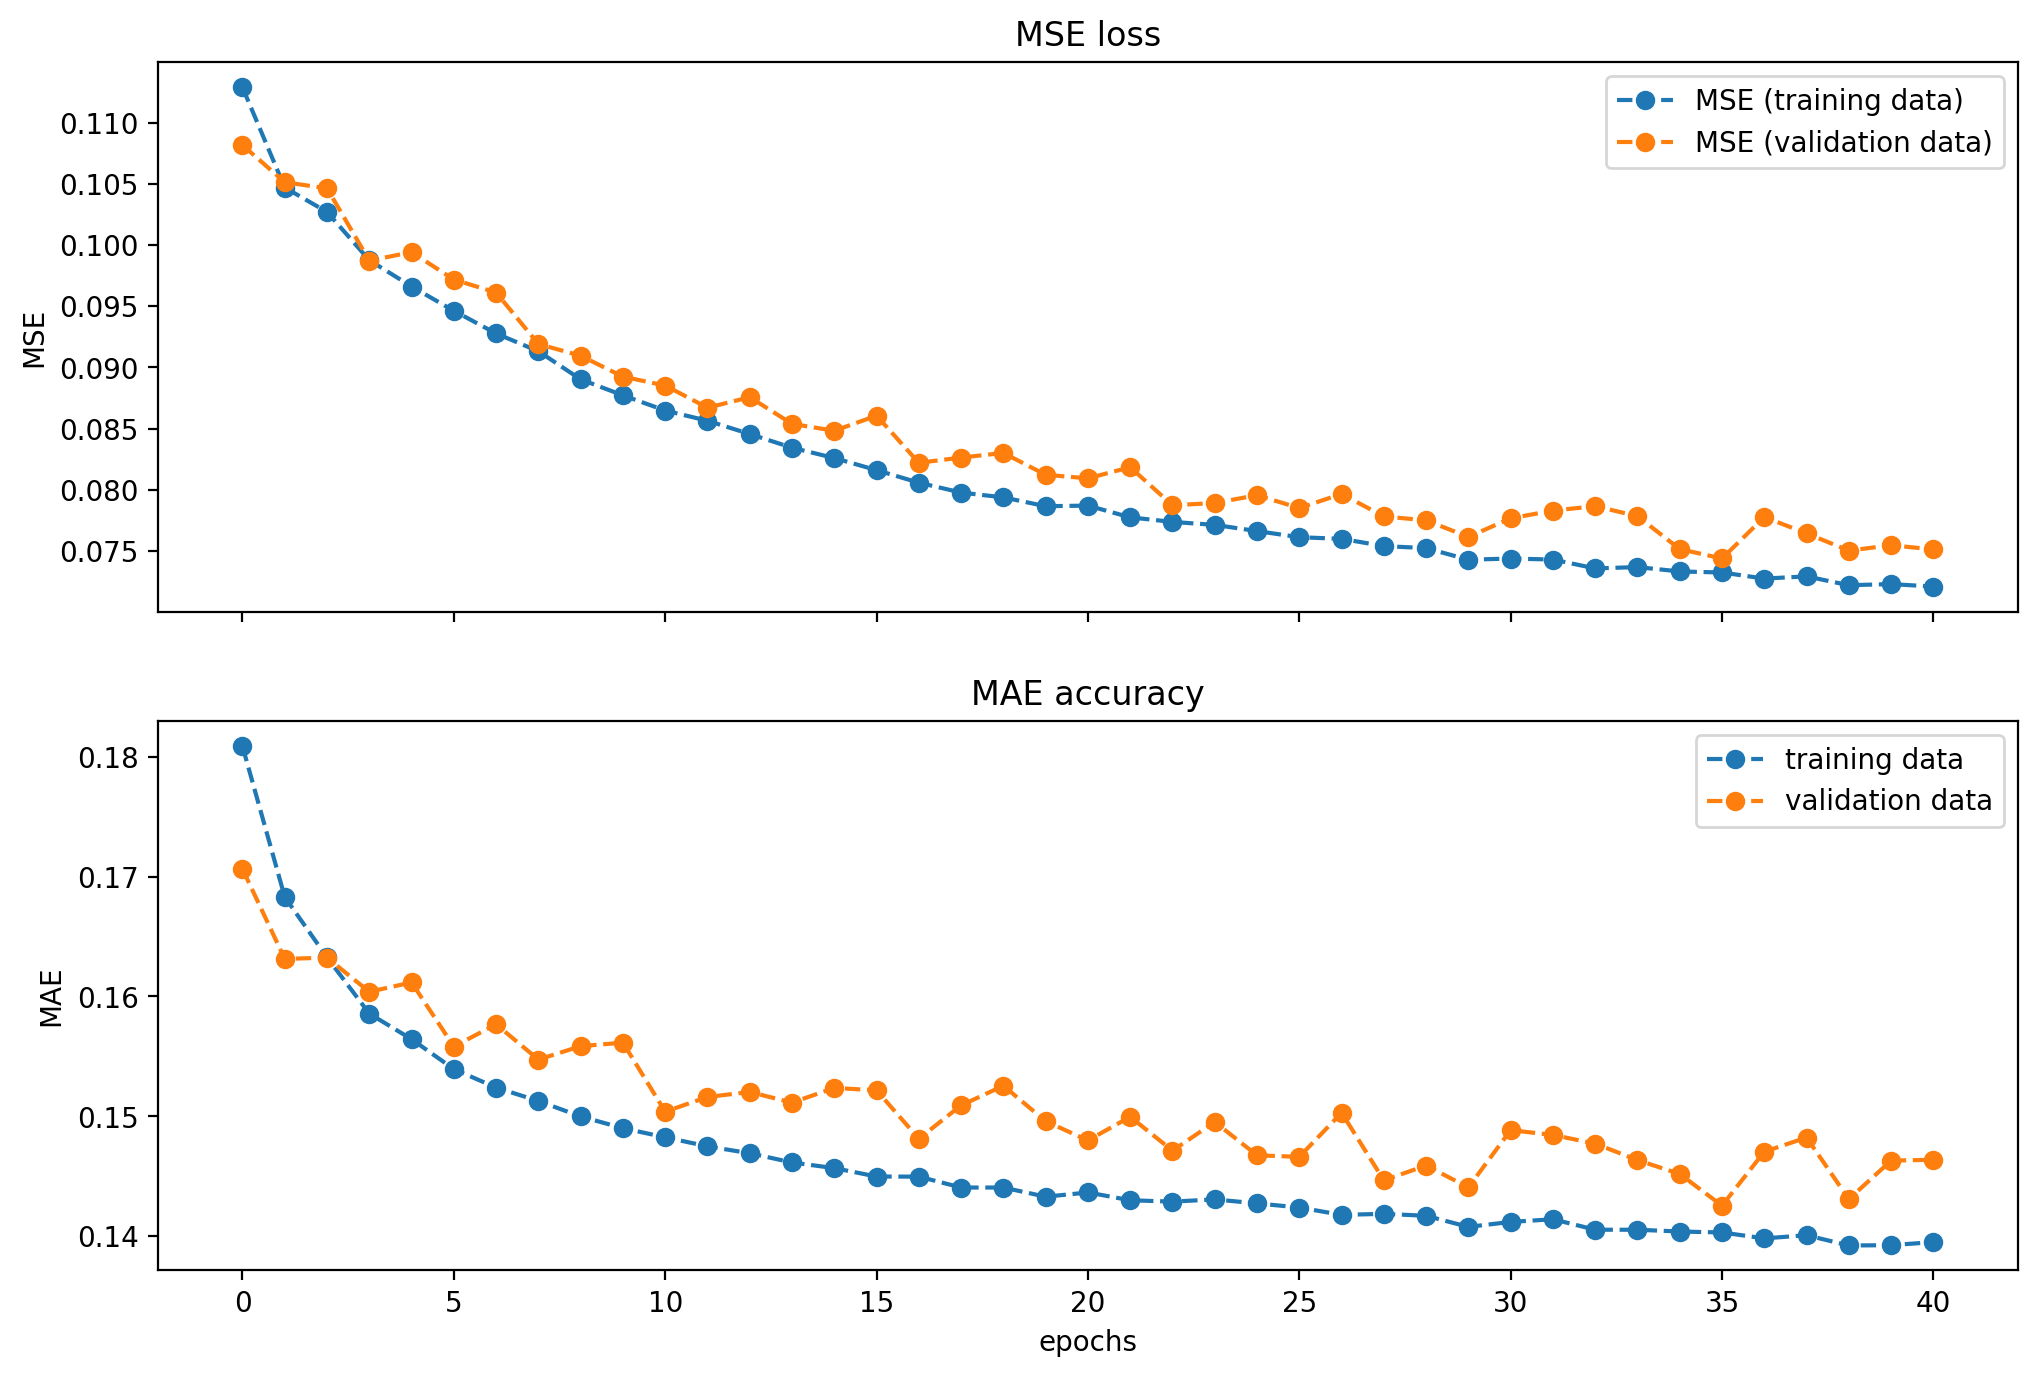

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [307]:
with open('ms2ds_210206_ALL_GNPS_positive_L1L2_training_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

## Improve things
- more validation rounds to decrease fluctuations
- add noise peaks

In [53]:
from ms2deepscore.data_generators import DataGeneratorAllSpectrums

dimension = len(spectrum_binner.known_bins)
same_prob_bins = list(zip(np.linspace(0,0.9,10), np.linspace(0.1,1,10)))

training_generator = DataGeneratorAllSpectrums(binned_spectrums_training, tanimoto_df,
                                               dim=dimension,
                                               same_prob_bins=same_prob_bins,
                                               augment_noise_max=20,
                                               augment_noise_intensity=0.05)

validation_generator = DataGeneratorAllSpectrums(binned_spectrums_val, tanimoto_df,
                                                 dim=dimension,
                                                 same_prob_bins=same_prob_bins,
                                                 num_runs=4,
                                                 augment_removal_max=0,
                                                 augment_removal_intensity=0,
                                                 augment_intensity=0,
                                                 augment_noise_max=0)

The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_noise_max is set from 10 (default) to 20
The value for augment_noise_intensity is set from 0.01 (default) to 0.05
13555 out of 15062 InChIKeys found in selected spectrums.
The value for same_prob_bins is set from [(0, 0.5), (0.5, 1)] (default) to [(0.0, 0.1), (0.1, 0.2), (0.2, 0.30000000000000004), (0.30000000000000004, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6000000000000001, 0.7000000000000001), (0.7000000000000001, 0.8), (0.8, 0.9), (0.9, 1.0)]
The value for augment_removal_max is set from 0.3 (default) to 0
The value for augment_removal_intensity is set from 0.2 (default) to 0
The value for augment_intensity is set from 0.4 (default) to 0
The value for augment_noise_max is set from 10 (default) to 0

In [54]:
model = SiameseModel(spectrum_binner, base_dims=(1000, 700, 600), embedding_dim=400,
                     dropout_rate=0.3)
model.summary()

Model: "base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_input (InputLayer)      [(None, 9947)]            0         
_________________________________________________________________
dense1 (Dense)               (None, 1000)              9948000   
_________________________________________________________________
normalization1 (BatchNormali (None, 1000)              4000      
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
dense2 (Dense)               (None, 700)               700700    
_________________________________________________________________
normalization2 (BatchNormali (None, 700)               2800      
_________________________________________________________________
dropout2 (Dropout)           (None, 700)               0      

In [55]:
epochs = 150
learning_rate = 0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 10
model_output_file = "ms2ds_210207_ALL_GNPS_positive_L1L2.hdf5"

model.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = model_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = model.model.fit(training_generator,
    validation_data=validation_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
3074/3074 [==============================] - 951s 305ms/step - loss: 0.1365 - mae: 0.1912 - val_loss: 0.1217 - val_mae: 0.1759

Epoch 00001: val_loss improved from inf to 0.12175, saving model to ms2ds_210207_ALL_GNPS_positive_L1L2.hdf5
Epoch 2/150
3074/3074 [==============================] - 869s 283ms/step - loss: 0.1162 - mae: 0.1695 - val_loss: 0.1190 - val_mae: 0.1705

Epoch 00002: val_loss improved from 0.12175 to 0.11900, saving model to ms2ds_210207_ALL_GNPS_positive_L1L2.hdf5
Epoch 3/150
3074/3074 [==============================] - 880s 286ms/step - loss: 0.1131 - mae: 0.1636 - val_loss: 0.1124 - val_mae: 0.1655

Epoch 00003: val_loss improved from 0.11900 to 0.11243, saving model to ms2ds_210207_ALL_GNPS_positive_L1L2.hdf5
Epoch 4/150
3074/3074 [==============================] - 860s 280ms/step - loss: 0.1102 - mae: 0.1607 - val_loss: 0.1059 - val_mae: 0.1604

Epoch 00004: val_loss improved from 0.11243 to 0.10589, saving model to ms2ds_210207_ALL_GNPS_positive_L1

3074/3074 [==============================] - 818s 266ms/step - loss: 0.0757 - mae: 0.1381 - val_loss: 0.0812 - val_mae: 0.1479

Epoch 00037: val_loss did not improve from 0.07785
Epoch 38/150
3074/3074 [==============================] - 825s 268ms/step - loss: 0.0754 - mae: 0.1379 - val_loss: 0.0778 - val_mae: 0.1466

Epoch 00038: val_loss improved from 0.07785 to 0.07782, saving model to ms2ds_210207_ALL_GNPS_positive_L1L2.hdf5
Epoch 39/150
3074/3074 [==============================] - 810s 263ms/step - loss: 0.0747 - mae: 0.1378 - val_loss: 0.0791 - val_mae: 0.1436

Epoch 00039: val_loss did not improve from 0.07782
Epoch 40/150
3074/3074 [==============================] - 823s 268ms/step - loss: 0.0746 - mae: 0.1369 - val_loss: 0.0796 - val_mae: 0.1482

Epoch 00040: val_loss did not improve from 0.07782
Epoch 41/150
3074/3074 [==============================] - 811s 264ms/step - loss: 0.0736 - mae: 0.1365 - val_loss: 0.0789 - val_mae: 0.1467

Epoch 00041: val_loss did not improve from

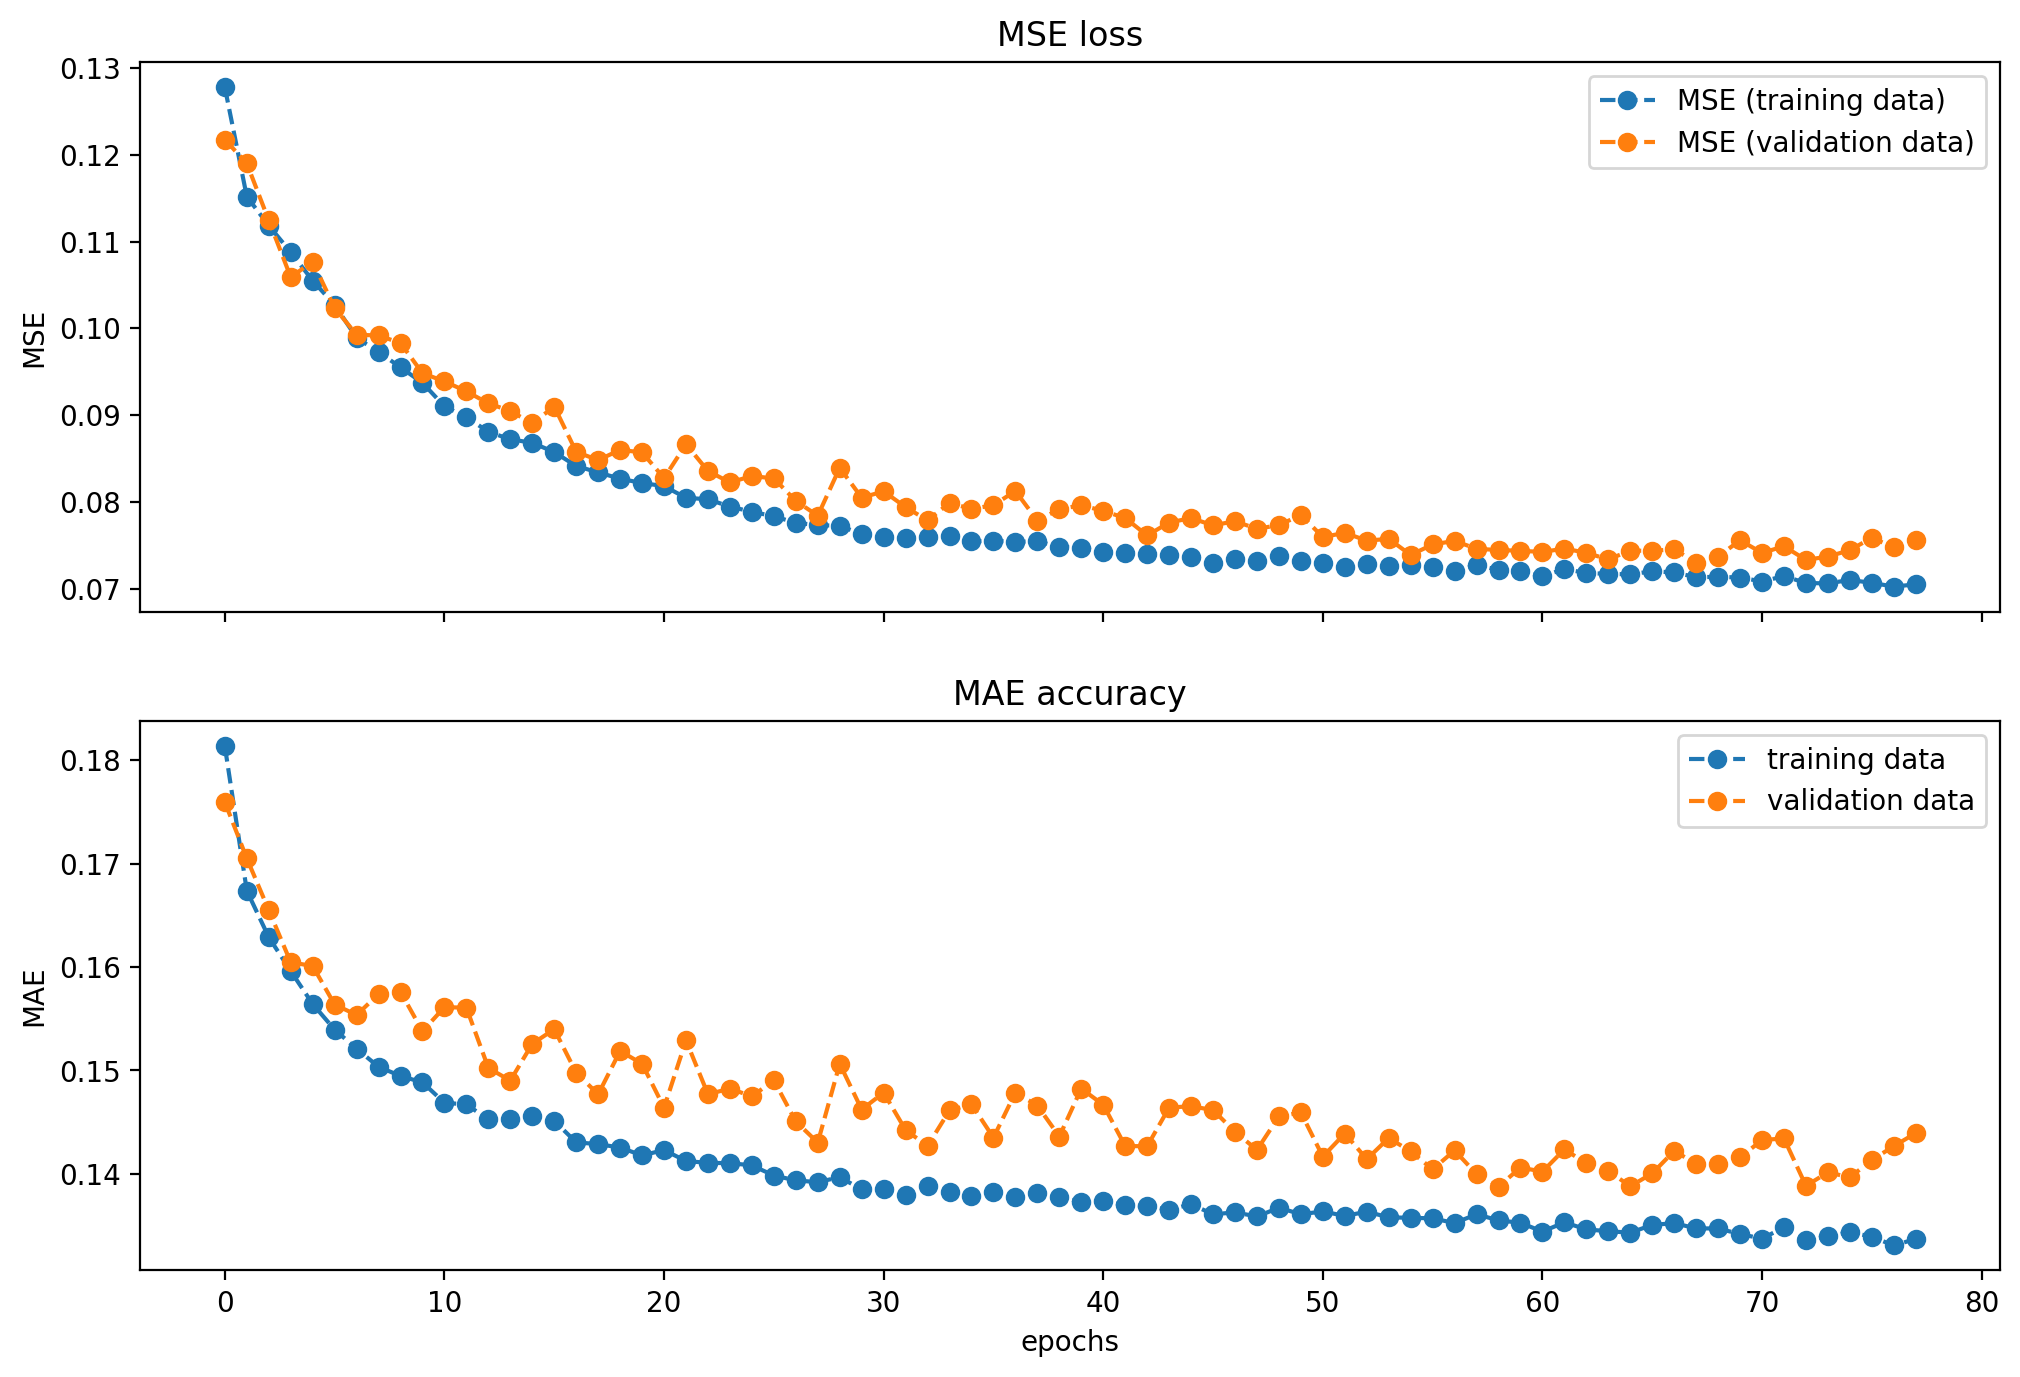

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

plt.savefig("ms2ds_210207_ALL_GNPS_positive_L1L2_history.pdf")

In [60]:
# took 19 hours!

In [61]:
# Save ms2deepscore style model (containing the SpectrumBinner)
model.save("ms2ds_siamese_210207_ALL_GNPS_positive_L1L2.hdf5")

In [308]:
from tensorflow.keras.models import load_model as load_keras_model

keras_model_file_early_stopping = "ms2ds_210206_ALL_GNPS_positive_L1L2.hdf5"
keras_model = load_keras_model(keras_model_file_early_stopping)

model_last_stop = SiameseModel(spectrum_binner, keras_model=keras_model)

In [309]:
model_last_stop.save("ms2ds_siamese_210207_ALL_GNPS_positive_L1L2_early_stop.hdf5")

In [63]:
from ms2deepscore import MS2DeepScore
similarity_score = MS2DeepScore(model)

In [64]:
similarities_val = similarity_score.matrix(spectrums_val, spectrums_val)

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5554/5554 [00:00<00:00, 11520.23it/s]


In [65]:
similarities_val.shape

(5554, 5554)

In [74]:
np.mean(np.abs(similarities_val - scores_ref))

ValueError: operands could not be broadcast together with shapes (5554,5554) (753,753) 

In [75]:
valIDs.shape

(753,)

In [76]:
type(valIDs)

numpy.ndarray

In [80]:
inchikey_idx_val = np.zeros(len(spectrums_val))
for i, spec in enumerate(spectrums_val):
    inchikey_idx_val[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_val = inchikey_idx_val.astype("int")

In [83]:
np.unique(inchikey_idx_val).shape

(753,)

In [84]:
scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_val[:], inchikey_idx_val[:])].copy()

In [85]:
scores_ref[:5, :5]

array([[1.        , 1.        , 0.5055332 , 0.48181309, 0.48181309],
       [1.        , 1.        , 0.5055332 , 0.48181309, 0.48181309],
       [0.5055332 , 0.5055332 , 1.        , 0.77694611, 0.77694611],
       [0.48181309, 0.48181309, 0.77694611, 1.        , 1.        ],
       [0.48181309, 0.48181309, 0.77694611, 1.        , 1.        ]])

In [86]:
similarities_val[:5, :5]

array([[1.        , 0.74913197, 0.67906699, 0.48215887, 0.52728163],
       [0.74913197, 1.        , 0.73962183, 0.5957692 , 0.50206141],
       [0.67906699, 0.73962183, 1.        , 0.50929135, 0.48015487],
       [0.48215887, 0.5957692 , 0.50929135, 1.        , 0.632441  ],
       [0.52728163, 0.50206141, 0.48015487, 0.632441  , 1.        ]])

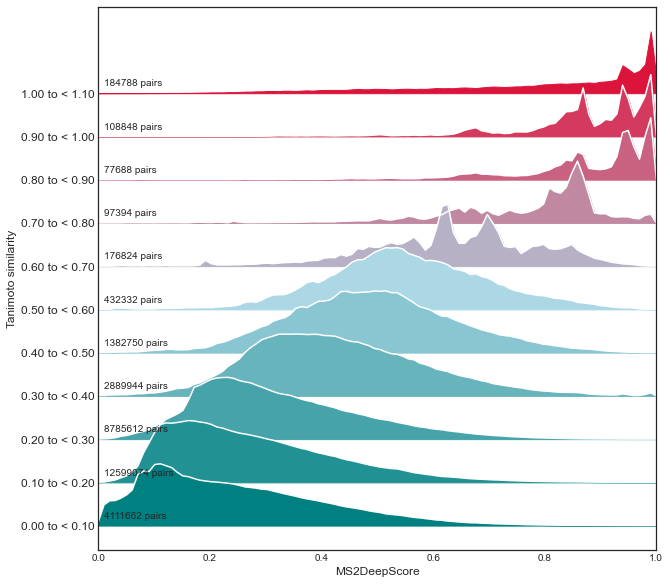

In [87]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, similarities_val, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")
plt.savefig("histogram_plot_210208_01.pdf")

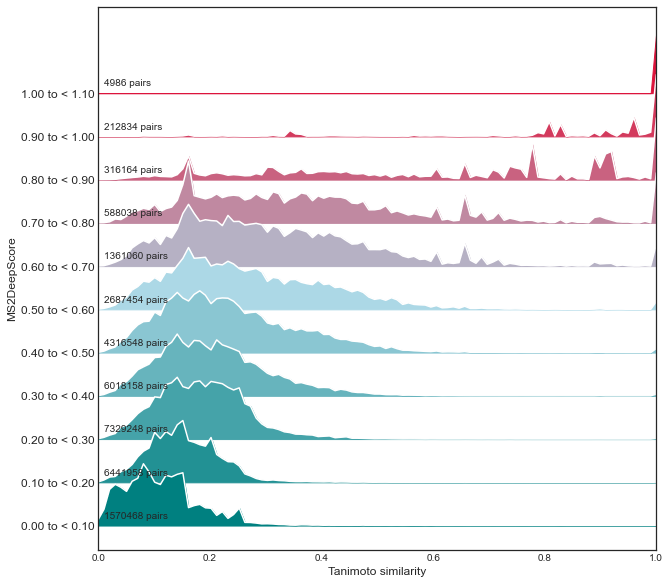

In [88]:
create_histograms_plot(similarities_val, scores_ref, n_bins=10, hist_resolution=100,
                          ref_score_name="MS2DeepScore", compare_score_name="Tanimoto similarity")
plt.savefig("histogram_plot_210208_01_inverse.pdf")

In [260]:
# try other plotting stuff

n_bins_x = 5
n_bins_y = 5



def derive_scatter_data(scores_ref, scores_compare, n_bins_x, n_bins_y):
    bins_x = np.linspace(0,1.0001, n_bins_x+1)
    bins_y = np.linspace(0,1.0001, n_bins_y+1)
    confusion_like_matrix = np.zeros((n_bins_x, n_bins_y))
    confusion_like_matrix_scatter = []
    for i in range(n_bins_x):
        for j in range(n_bins_y):
            idx = np.where((scores_ref>=bins_x[i]) & (scores_ref<bins_x[i+1]) &
                          (scores_compare>=bins_y[j]) & (scores_compare<bins_y[j+1]))
            confusion_like_matrix[i, j] = idx[0].shape[0]
            confusion_like_matrix_scatter.append(((bins_x[i] + bins_x[i+1])/2,
                                                 (bins_y[j] + bins_y[j+1])/2,
                                                 idx[0].shape[0]))
    return confusion_like_matrix, confusion_like_matrix_scatter

confusion_like_matrix, confusion_like_matrix_scatter = derive_scatter_data(scores_ref, similarities_val, n_bins_x, n_bins_y)

In [264]:
summed_tanimoto = []
for i in range(n_bins_x):
    for j in range(n_bins_y):
        summed_tanimoto.append(confusion_like_matrix[i,:].sum())

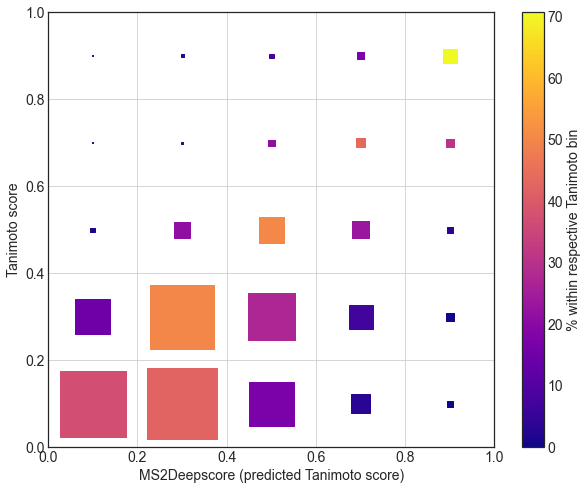

In [304]:
def plot_confusion_like_matrix(confusion_like_matrix_scatter, confusion_like_matrix,
                              xlabel="MS2DeepScore", ylabel="Tanimoto score", max_size=5000):
    summed_tanimoto = []
    for i in range(confusion_like_matrix.shape[0]):
        for j in range(confusion_like_matrix.shape[1]):
            summed_tanimoto.append(confusion_like_matrix[i,:].sum())
    
    sizes = np.array([x[2] for x in confusion_like_matrix_scatter])
    colors = 100*sizes/np.array(summed_tanimoto)  # color percentage
    sizes = sizes/np.max(sizes)

    plt.style.use('seaborn-white')
    plt.figure(figsize=(10, 8))
    plt.scatter([x[1] for x in confusion_like_matrix_scatter],
               [x[0] for x in confusion_like_matrix_scatter], marker='s', c=colors, cmap="plasma", #"inferno",
               s=sizes*max_size)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label('% within respective Tanimoto bin', rotation=90, fontsize=14)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.clim(0)
    plt.grid(True)
    
plot_confusion_like_matrix(confusion_like_matrix_scatter, confusion_like_matrix,
                           "MS2Deepscore (predicted Tanimoto score)", "Tanimoto score")   
plt.savefig("gridplot_1.pdf")

In [ ]:
plot_confusion_like_matrix(confusion_like_matrix_scatter, confusion_like_matrix,
                           "MS2DeepScore", "Tanimoto score")   
plt.savefig("gridplot_1.pdf")

In [ ]:
confusion_like_matrix_scatter = derive_scatter_data(scores_ref, similarities_val, 10, 10)

In [259]:
[x[2] for x in confusion_like_matrix_scatter[:10]]

[699736, 1145188, 876390, 656238, 408724, 213600, 84258, 28268, 6650, 1092]

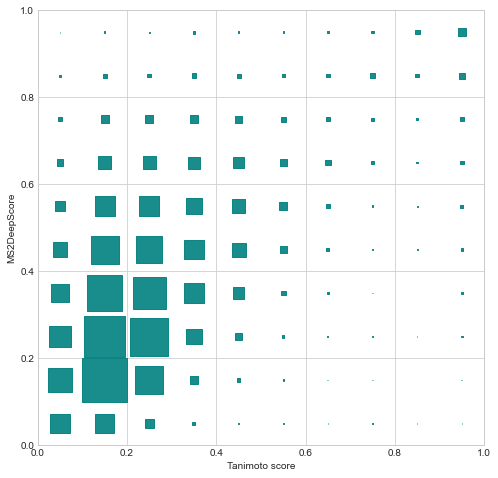

In [256]:
sizes = np.array([x[2]/1e5 for x in confusion_like_matrix_scatter])
sizes = sizes/np.max(sizes)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in confusion_like_matrix_scatter],
           [x[1] for x in confusion_like_matrix_scatter], marker='s', c="teal", alpha=0.9,
           s=sizes*2000)
plt.xlabel("Tanimoto score")
plt.ylabel("MS2DeepScore")
plt.xlim(-0, 1)
plt.ylim(-0, 1)
plt.grid(True)
plt.savefig("gridplot_2.pdf")

In [89]:
tanimoto_df.index.values[:10]

array(['TXZUPPVCNIMVHW', 'DGYASNDHNSXGSL', 'JWYUFVNJZUSCSM',
       'ZQXBVPNSSGEUCM', 'WIOKWEJDRXNVSH', 'NJMQSVWMCODQIP',
       'VBFKEZGCUWHGSK', 'KJAYXCCGPDNITQ', 'NTAHMPNXQOYXSX',
       'YALMHTJLWDGANA'], dtype=object)

In [97]:
test_df = tanimoto_df.iloc[:5,:5].copy()
test_df.index = [x[:5] for x in test_df.index]
test_df.head()

'CRQZWNMPCIFJKX-AMXJBSLBSA-N'

In [103]:
A, B = validation_generator.__getitem__(0)
A[0].shape, len(A), len(B)

((32, 9947), 2, 32)

In [169]:
A[0][:1,:].shape

(1, 9947)

In [119]:
test2 = model.base.predict(A[0][:1,:])

In [121]:
np.all(test1 == test2)

True

In [124]:
from tensorflow.keras.models import Model

partial_model = Model(model.base.inputs, model.base.layers[-1].output)

In [141]:
test3 = partial_model(A[0][:1,:], training=True)
test4 = partial_model(A[0][:1,:], training=True)
test5 = partial_model(A[0][:1,:], training=False)

In [185]:
tests = model.base.predict(A[0][:10,:])
print(tests[:, :5])

[[33.507706   0.         0.         0.         2.6305685]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        11.503168   0.        56.738136   0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        10.742525   0.         0.         4.180787 ]
 [ 0.        12.9788475  0.         0.        15.98713  ]
 [ 0.         0.         0.         3.9017718  0.       ]
 [ 0.         0.        10.888642   0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         2.5960035  0.         3.9906452  0.       ]]


In [189]:
tests = partial_model(A[0][:10,:], training=False)
print(tests[:, :5])

tf.Tensor(
[[33.507706   0.         0.         0.         2.6305685]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        11.503168   0.        56.738136   0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        10.742525   0.         0.         4.180787 ]
 [ 0.        12.9788475  0.         0.        15.98713  ]
 [ 0.         0.         0.         3.9017718  0.       ]
 [ 0.         0.        10.888642   0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         2.5960035  0.         3.9906452  0.       ]], shape=(10, 5), dtype=float32)


In [201]:
tests = partial_model(A[0][:10,:], training=True)
print(tests[:, :5])

tf.Tensor(
[[48.40637    0.         0.         0.7128589  0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        78.11234   22.31468   49.78434    0.       ]
 [ 0.         0.         3.6432474  0.         0.       ]
 [ 0.        23.705656   0.         0.         0.       ]
 [ 0.         0.         0.         0.        12.701493 ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         4.4854426  6.940226   0.       ]
 [ 6.484842   0.         0.         0.         0.       ]
 [ 0.         0.        16.069044   0.         0.       ]], shape=(10, 5), dtype=float32)


In [194]:
print(tests.numpy()[:, :5])

[[33.60934    0.         0.         0.         2.2179909]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        11.818512   0.        56.52915    0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.        10.879292   0.         0.         4.252634 ]
 [ 0.        12.874792   0.         0.        16.22636  ]
 [ 0.         0.         0.         3.522244   0.       ]
 [ 0.         0.        11.052591   0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         2.689671   0.         3.8610127  0.       ]]


In [151]:
from tensorflow.python.keras.backend import eager_learning_phase_scope

fn = K.function([model.base.input], [model.base.layers[-1].output])

# run in test mode, i.e. 0 means test
with eager_learning_phase_scope(value=0):
    output_test = fn(A[0][:1,:])

# run in training mode, i.e. 1 means training
with eager_learning_phase_scope(value=1):
    output_train = fn(A[0][:1,:])

In [168]:
np.all(test2 == test1)

False

In [111]:
from tensorflow import keras
import tensorflow.keras.backend as K
# for some model with dropout ...
f = K.function([model.model.layers[2].layers[0].input, K.learning_phase()],
               [model.model.layers[2].layers[-1].output])

ValueError: Input tensors to a Functional must come from `tf.keras.Input`. Received: 0 (missing previous layer metadata).

In [316]:
import time

tstart = time.time()
for _ in range(10):
    A, B = training_generator.__getitem__(0)
dtime = time.time() - tstart    
print(dtime)

1.9526996612548828


In [312]:
A[0].shape

(32, 9947)

In [315]:
import time

tstart = time.time()
for _ in range(10):
    A, B = validation_generator.__getitem__(0)
dtime = time.time() - tstart    
print(dtime)

0.8704805374145508
